# SOYKOK Aylin 28711545
# CELIK Simay 28713301

<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

Cloning into 'deep-learning-polytech-tp6-7'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 22 (delta 3), reused 7 (delta 1), pack-reused 8 (from 1)
Receiving objects: 100% (22/22), 84.12 MiB | 14.29 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (7/7), done.
--2024-10-28 22:24:27--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2024-10-28 22:24:27--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting 

In [2]:
# %run 'utils.py'
import matplotlib.pyplot as plt
plt.ion()
import numpy as np

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, keep_all=False):
        self.reset()
        self.data = None
        if keep_all:
            self.data = []

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.data is not None:
            self.data.append(val)
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class TrainLossPlot(object):
    def __init__(self):
        self.loss_train = []
        self.fig = plt.figure()

    def update(self, loss_train):
        self.loss_train.append(loss_train)

    def plot(self):
        plt.figure(self.fig.number)
        plt.clf()
        plt.plot(np.array(self.loss_train))
        plt.title("Train loss / batch")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
        plt.draw_all()
        plt.pause(1e-3)

class AccLossPlot(object):
    def __init__(self):
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
        self.fig = plt.figure()

    def update(self, loss_train, loss_test, acc_train, acc_test,plotting=True):
        self.loss_train.append(loss_train)
        self.loss_test.append(loss_test)
        self.acc_train.append(acc_train)
        self.acc_test.append(acc_test)
        if plotting:
            plt.figure(self.fig.number)
            plt.clf()
            plt.subplot(1,2,1)
            plt.plot(np.array(self.acc_train), label="acc. train")
            plt.plot(np.array(self.acc_test), label="acc. test")
            plt.title("Accuracy / epoch")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.subplot(1,2,2)
            plt.plot(np.array(self.loss_train), label="loss train")
            plt.plot(np.array(self.loss_test), label="loss test")
            plt.title("Loss / epoch")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()
            plt.draw_all()
            plt.pause(1e-3)


In [3]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

#from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [4]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """


    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset1(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset1(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:09<00:00, 1.01MB/s]


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 138kB/s]


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.19MB/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw

=== EPOCH 1 =====



[TRAIN Batch 000/469]	Time 0.463s (0.463s)	Loss 2.3113 (2.3113)	Prec@1   8.6 (  8.6)	Prec@5  43.8 ( 43.8)


<Figure size 640x480 with 0 Axes>

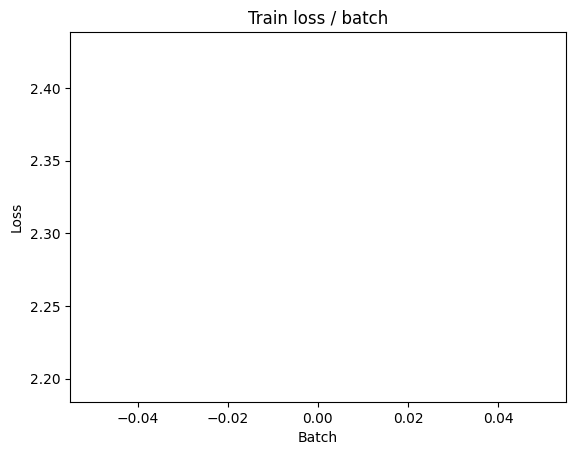

[TRAIN Batch 200/469]	Time 0.006s (0.023s)	Loss 0.3548 (1.1990)	Prec@1  93.8 ( 64.4)	Prec@5  97.7 ( 90.3)


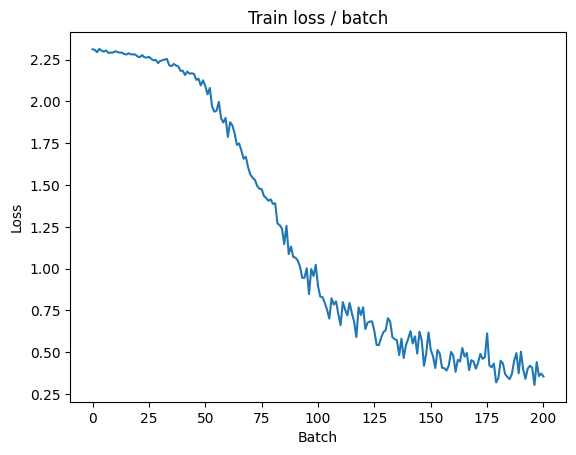

[TRAIN Batch 400/469]	Time 0.004s (0.020s)	Loss 0.2374 (0.7299)	Prec@1  93.8 ( 78.6)	Prec@5  99.2 ( 95.0)


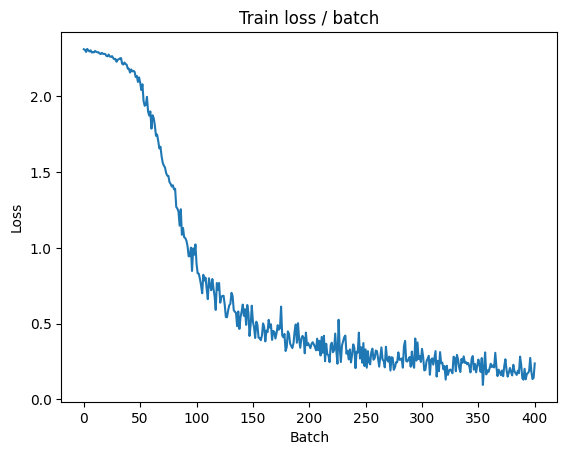


===============> Total time 9s	Avg loss 0.6498	Avg Prec@1 80.98 %	Avg Prec@5 95.66 %

[EVAL Batch 000/079]	Time 0.104s (0.104s)	Loss 0.0988 (0.0988)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.1484	Avg Prec@1 95.62 %	Avg Prec@5 99.92 %



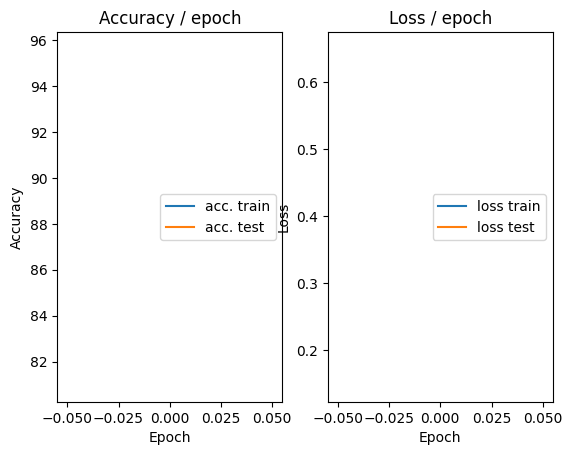

=== EPOCH 2 =====

[TRAIN Batch 000/469]	Time 0.118s (0.118s)	Loss 0.1180 (0.1180)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


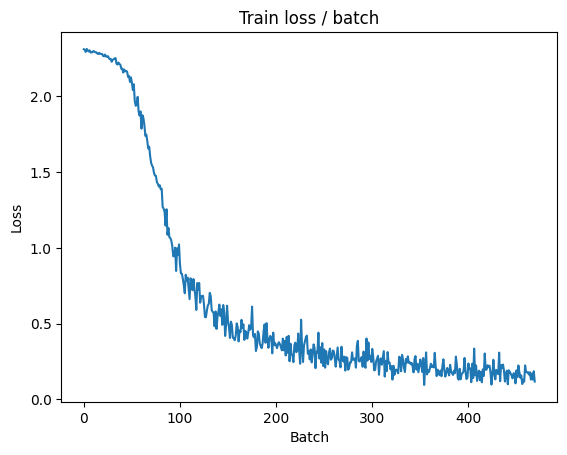

[TRAIN Batch 200/469]	Time 0.017s (0.020s)	Loss 0.1189 (0.1386)	Prec@1  96.1 ( 95.8)	Prec@5  99.2 ( 99.9)


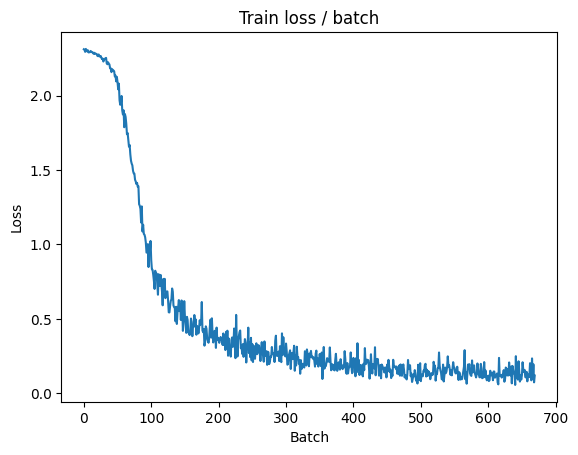

[TRAIN Batch 400/469]	Time 0.019s (0.019s)	Loss 0.0766 (0.1248)	Prec@1  98.4 ( 96.3)	Prec@5 100.0 ( 99.9)


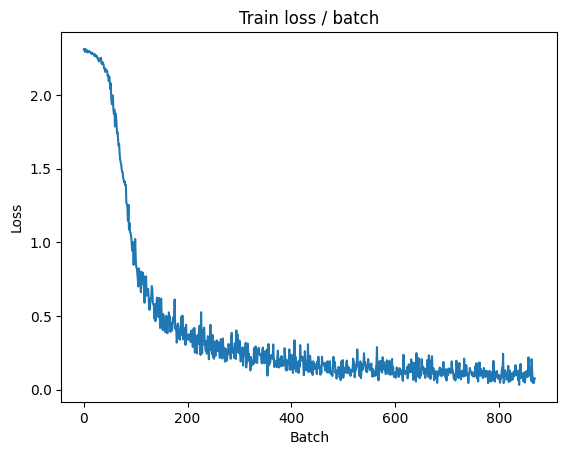


===============> Total time 8s	Avg loss 0.1215	Avg Prec@1 96.45 %	Avg Prec@5 99.87 %

[EVAL Batch 000/079]	Time 0.114s (0.114s)	Loss 0.0448 (0.0448)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0774	Avg Prec@1 97.69 %	Avg Prec@5 99.99 %



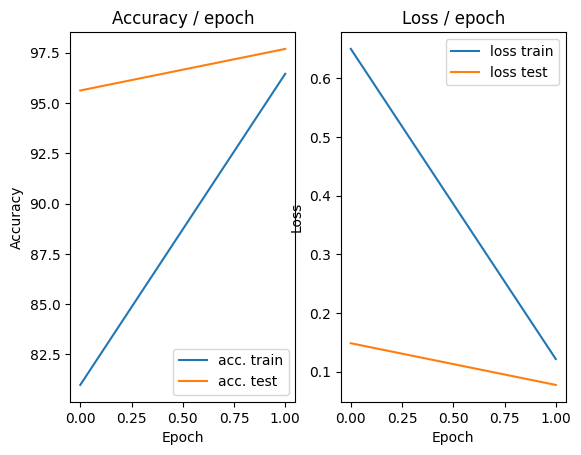

=== EPOCH 3 =====

[TRAIN Batch 000/469]	Time 0.130s (0.130s)	Loss 0.0381 (0.0381)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


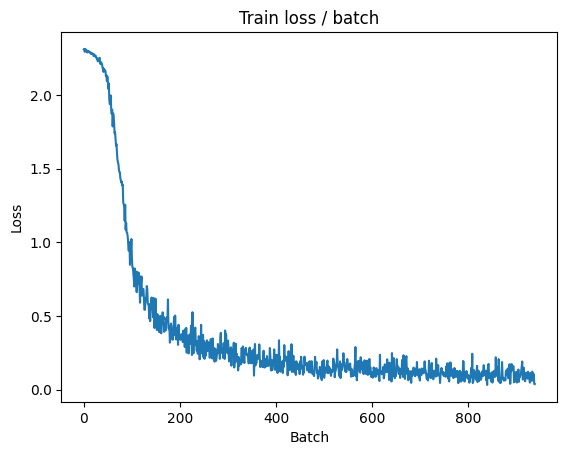

[TRAIN Batch 200/469]	Time 0.026s (0.017s)	Loss 0.0494 (0.0833)	Prec@1  97.7 ( 97.5)	Prec@5 100.0 ( 99.9)


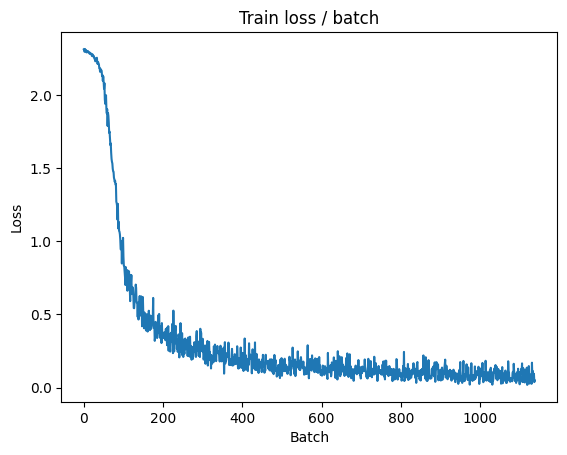

[TRAIN Batch 400/469]	Time 0.003s (0.019s)	Loss 0.0442 (0.0819)	Prec@1  99.2 ( 97.6)	Prec@5 100.0 ( 99.9)


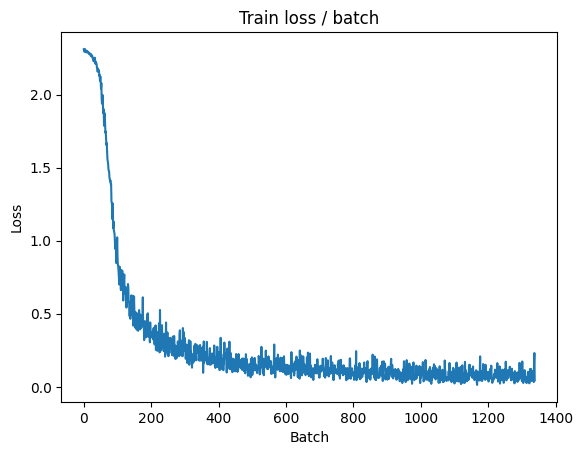


===============> Total time 8s	Avg loss 0.0800	Avg Prec@1 97.67 %	Avg Prec@5 99.94 %

[EVAL Batch 000/079]	Time 0.109s (0.109s)	Loss 0.0243 (0.0243)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0630	Avg Prec@1 98.00 %	Avg Prec@5 100.00 %



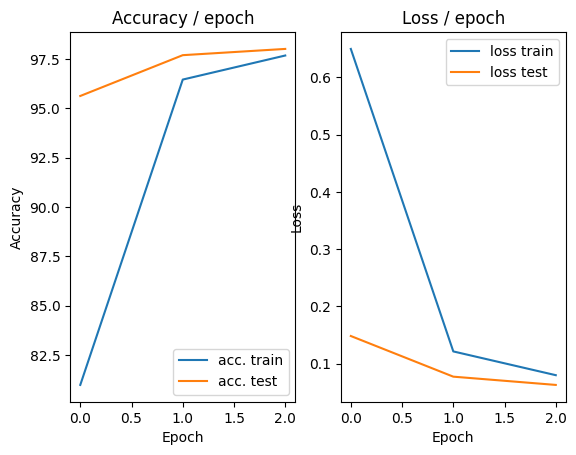

=== EPOCH 4 =====

[TRAIN Batch 000/469]	Time 0.132s (0.132s)	Loss 0.0889 (0.0889)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


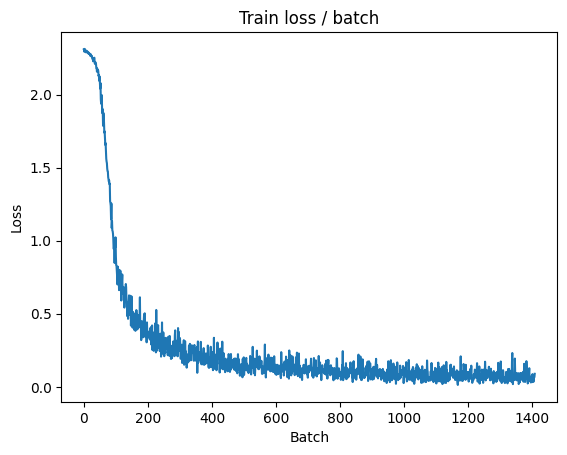

[TRAIN Batch 200/469]	Time 0.004s (0.017s)	Loss 0.0802 (0.0631)	Prec@1  96.1 ( 98.1)	Prec@5 100.0 (100.0)


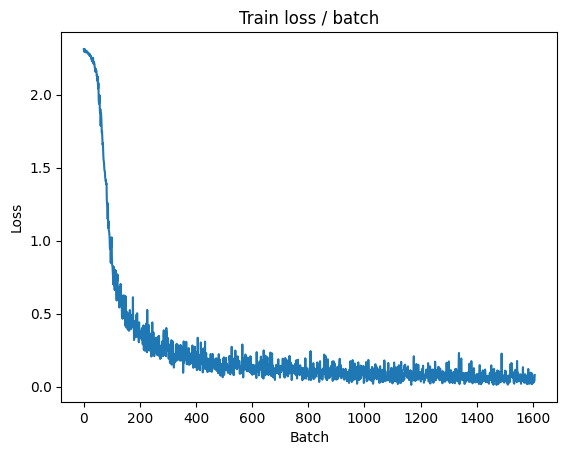

[TRAIN Batch 400/469]	Time 0.003s (0.017s)	Loss 0.0220 (0.0629)	Prec@1  99.2 ( 98.1)	Prec@5 100.0 (100.0)


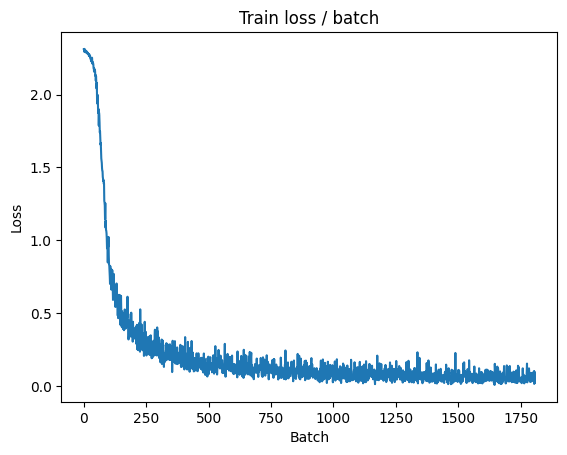


===============> Total time 8s	Avg loss 0.0620	Avg Prec@1 98.14 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 0.0245 (0.0245)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0514	Avg Prec@1 98.44 %	Avg Prec@5 100.00 %



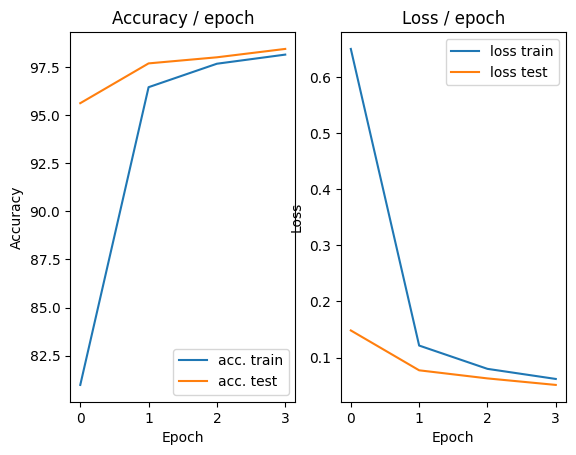

=== EPOCH 5 =====

[TRAIN Batch 000/469]	Time 0.123s (0.123s)	Loss 0.0464 (0.0464)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


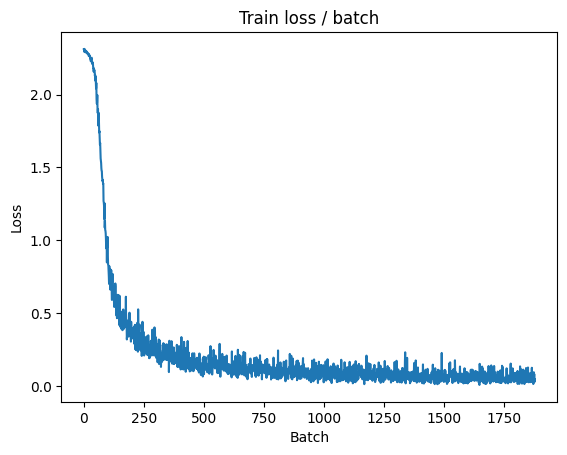

[TRAIN Batch 200/469]	Time 0.006s (0.017s)	Loss 0.0776 (0.0522)	Prec@1  97.7 ( 98.5)	Prec@5 100.0 (100.0)


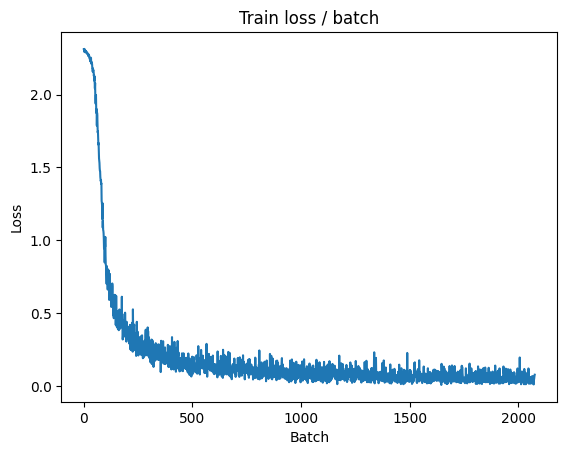

[TRAIN Batch 400/469]	Time 0.015s (0.016s)	Loss 0.0553 (0.0510)	Prec@1  96.9 ( 98.5)	Prec@5 100.0 (100.0)


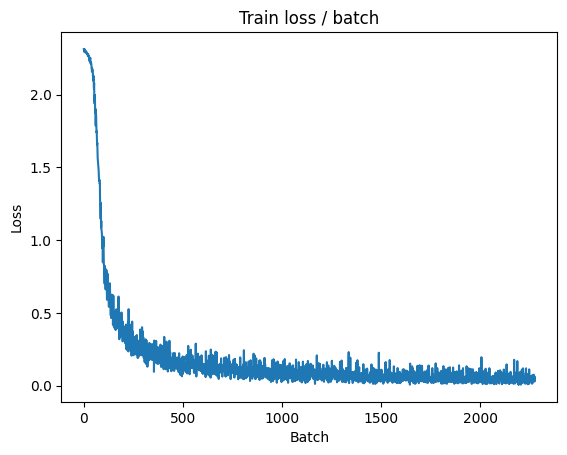


===============> Total time 8s	Avg loss 0.0518	Avg Prec@1 98.49 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.116s (0.116s)	Loss 0.0247 (0.0247)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0447	Avg Prec@1 98.50 %	Avg Prec@5 100.00 %



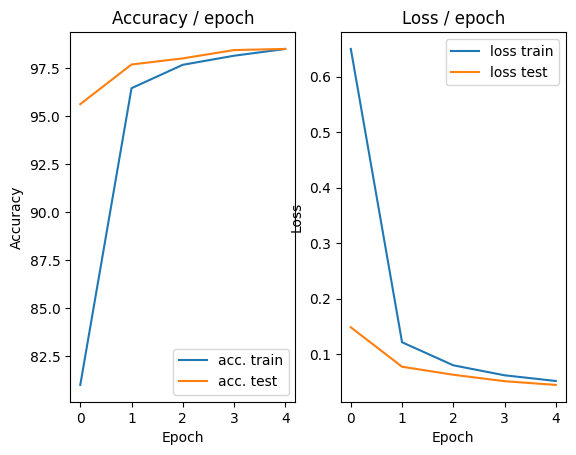

In [ ]:
main(128, 0.1, cuda=True)

CIFAR 10


In [11]:
#generalizing the class / functions
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0))
        # We then define fully connected layers as a classifier

        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset2(dataset,batch_size, cuda=False,transformation=[transforms.ToTensor()],):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = dataset(PATH, train=True, download=True,
        transform=transforms.Compose(transformation)) #
    val_dataset = dataset(PATH, train=False, download=True,
        transform=transforms.Compose(transformation))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False,verbose=True):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0 and verbose :
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary

    print('\n===============> Total time {batch_time:d}s\t'
        'Avg loss {loss.avg:.4f}\t'
        'Avg Prec@1 {top1.avg:5.2f} %\t'
        'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
        batch_time=int(avg_batch_time.sum), loss=avg_loss,
        top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=10, cuda=False,verbose=True, plotting=True):


    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset2(datasets.CIFAR10,batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    results_train = {}
    results_test = {}
    # We iterate on the epochs

    for i in range(epochs):
        if verbose:
            print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda, verbose=verbose)
        results_train[i] = [top1_acc.avg, avg_top5_acc.avg, loss.avg]
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda,verbose=verbose)
        results_test[i] = [top1_acc_test.avg, top5_acc_test.avg, loss_test.avg]
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg,plotting=plotting)
    return results_train, results_test



Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.127s (0.127s)	Loss 2.3026 (2.3026)	Prec@1  14.1 ( 14.1)	Prec@5  51.6 ( 51.6)


<Figure size 640x480 with 0 Axes>

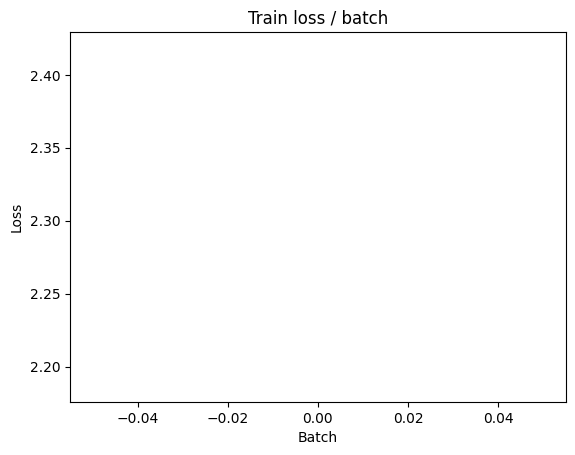

[TRAIN Batch 200/391]	Time 0.026s (0.021s)	Loss 1.9705 (2.2365)	Prec@1  27.3 ( 16.0)	Prec@5  81.2 ( 62.4)


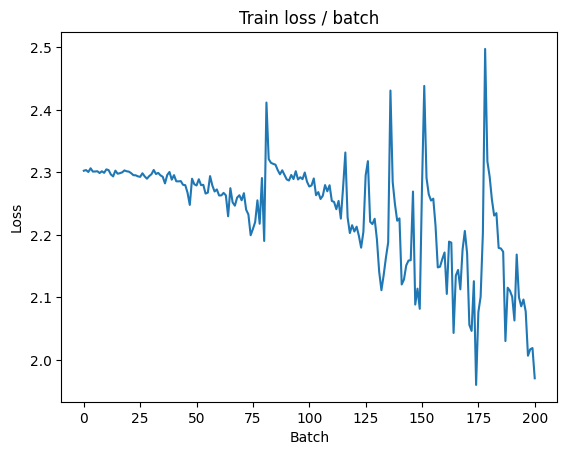


===============> Total time 9s	Avg loss 2.1205	Avg Prec@1 22.02 %	Avg Prec@5 70.28 %

[EVAL Batch 000/079]	Time 0.121s (0.121s)	Loss 1.8162 (1.8162)	Prec@1  41.4 ( 41.4)	Prec@5  89.1 ( 89.1)

===============> Total time 1s	Avg loss 1.8475	Avg Prec@1 34.92 %	Avg Prec@5 85.74 %



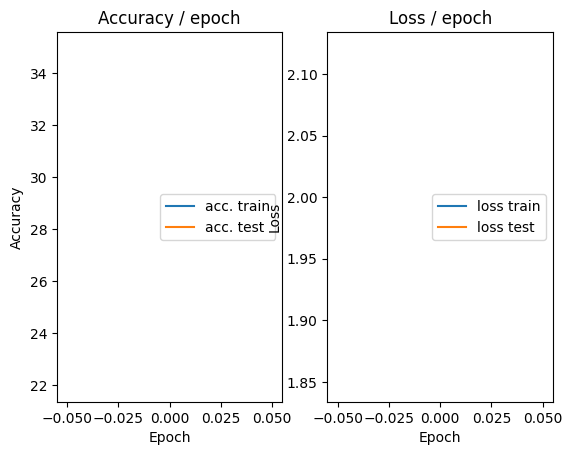

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.126s (0.126s)	Loss 1.9345 (1.9345)	Prec@1  29.7 ( 29.7)	Prec@5  79.7 ( 79.7)


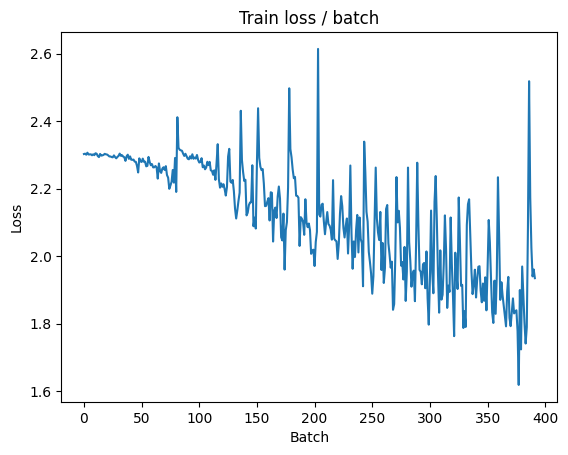

[TRAIN Batch 200/391]	Time 0.029s (0.022s)	Loss 1.5137 (1.7418)	Prec@1  46.9 ( 37.1)	Prec@5  89.1 ( 86.6)


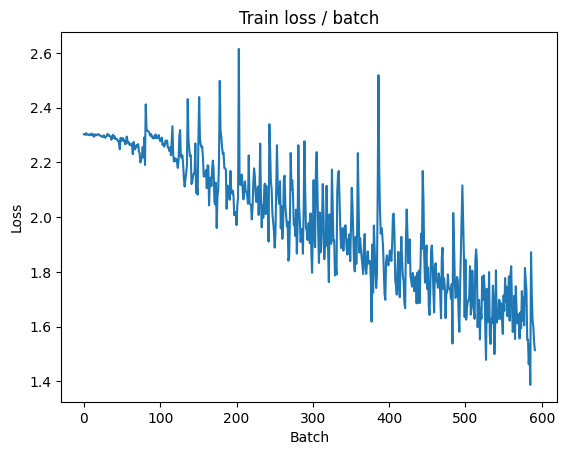


===============> Total time 9s	Avg loss 1.6559	Avg Prec@1 40.14 %	Avg Prec@5 88.50 %

[EVAL Batch 000/079]	Time 0.120s (0.120s)	Loss 1.4343 (1.4343)	Prec@1  45.3 ( 45.3)	Prec@5  91.4 ( 91.4)

===============> Total time 1s	Avg loss 1.4571	Avg Prec@1 48.22 %	Avg Prec@5 92.10 %



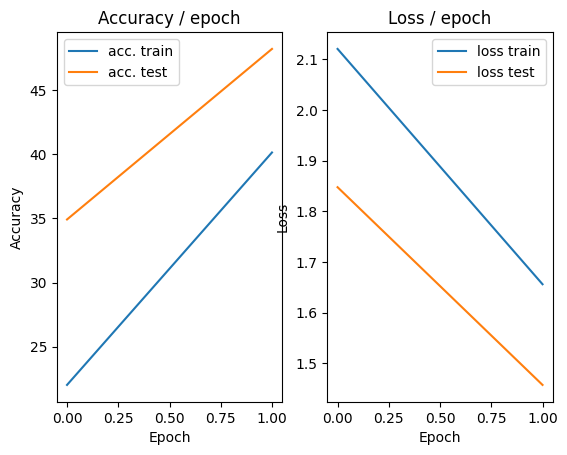

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.146s (0.146s)	Loss 1.3144 (1.3144)	Prec@1  50.8 ( 50.8)	Prec@5  93.8 ( 93.8)


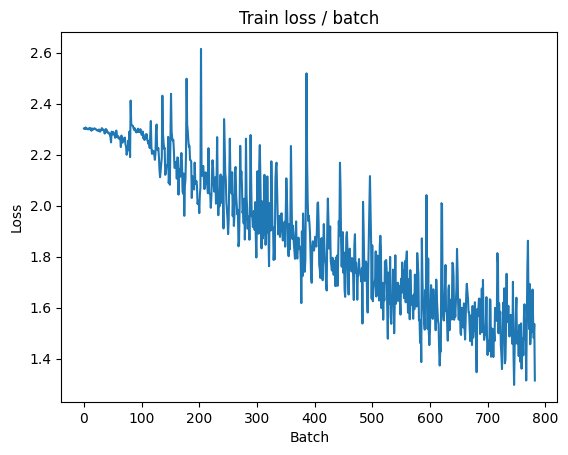

[TRAIN Batch 200/391]	Time 0.010s (0.026s)	Loss 1.3414 (1.4489)	Prec@1  57.0 ( 47.9)	Prec@5  91.4 ( 92.1)


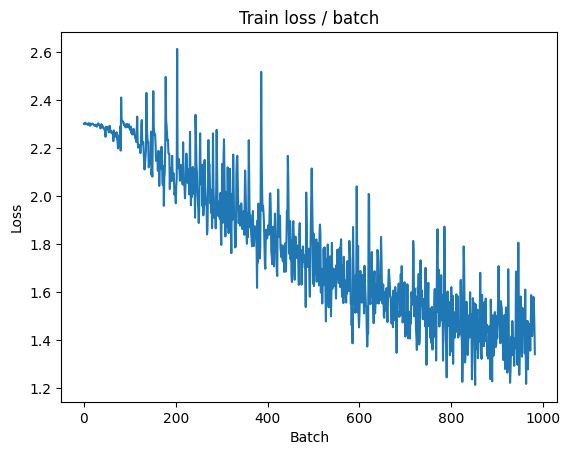


===============> Total time 10s	Avg loss 1.4127	Avg Prec@1 49.34 %	Avg Prec@5 92.71 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 1.3193 (1.3193)	Prec@1  51.6 ( 51.6)	Prec@5  92.2 ( 92.2)

===============> Total time 1s	Avg loss 1.3497	Avg Prec@1 52.23 %	Avg Prec@5 93.56 %



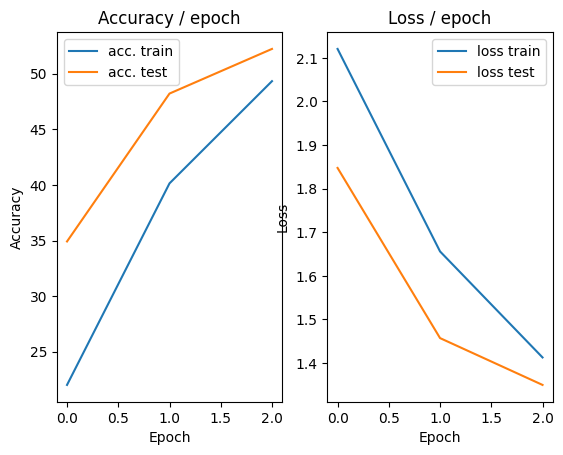

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.133s (0.133s)	Loss 1.3225 (1.3225)	Prec@1  53.1 ( 53.1)	Prec@5  93.8 ( 93.8)


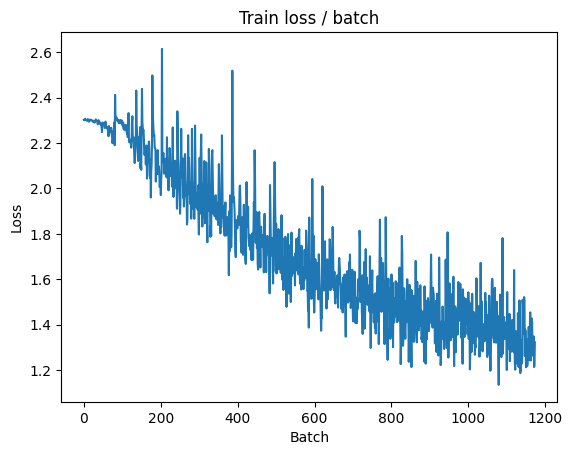

[TRAIN Batch 200/391]	Time 0.008s (0.022s)	Loss 1.1487 (1.2867)	Prec@1  60.9 ( 54.4)	Prec@5  95.3 ( 94.2)


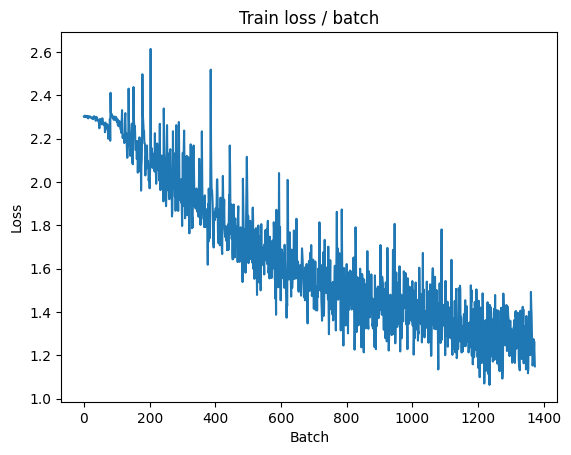


===============> Total time 9s	Avg loss 1.2654	Avg Prec@1 55.06 %	Avg Prec@5 94.45 %

[EVAL Batch 000/079]	Time 0.293s (0.293s)	Loss 1.2034 (1.2034)	Prec@1  57.8 ( 57.8)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.2392	Avg Prec@1 55.61 %	Avg Prec@5 95.00 %



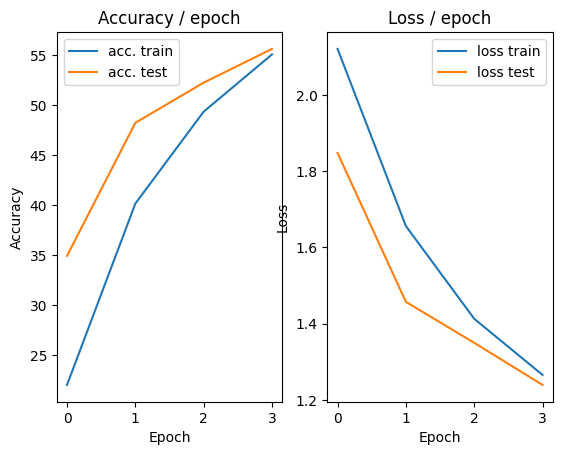

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.122s (0.122s)	Loss 1.1241 (1.1241)	Prec@1  60.9 ( 60.9)	Prec@5  93.8 ( 93.8)


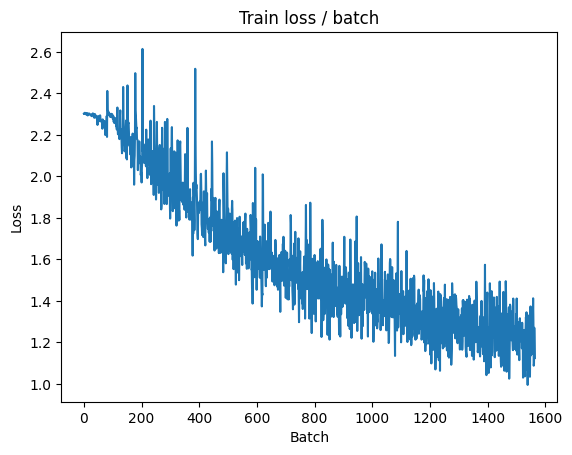

[TRAIN Batch 200/391]	Time 0.018s (0.022s)	Loss 1.1089 (1.1450)	Prec@1  64.8 ( 59.6)	Prec@5  95.3 ( 95.7)


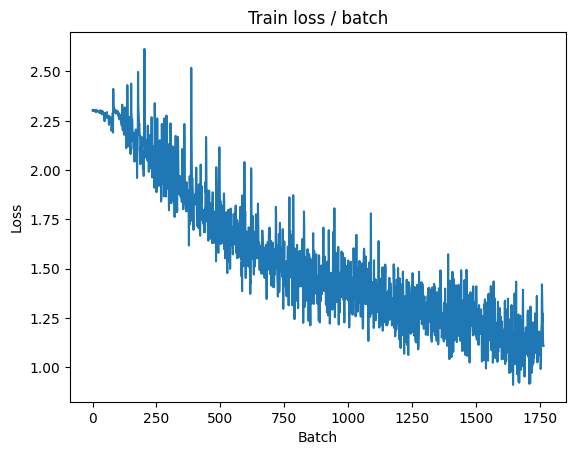


===============> Total time 8s	Avg loss 1.1311	Avg Prec@1 59.91 %	Avg Prec@5 95.76 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 1.0629 (1.0629)	Prec@1  64.1 ( 64.1)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.1891	Avg Prec@1 56.48 %	Avg Prec@5 96.01 %



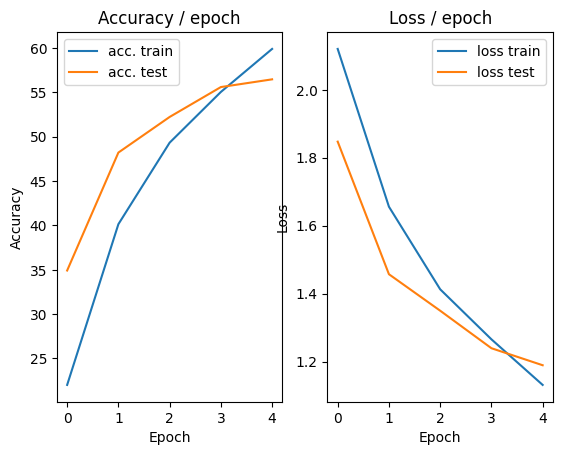

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.143s (0.143s)	Loss 1.0517 (1.0517)	Prec@1  63.3 ( 63.3)	Prec@5  96.1 ( 96.1)


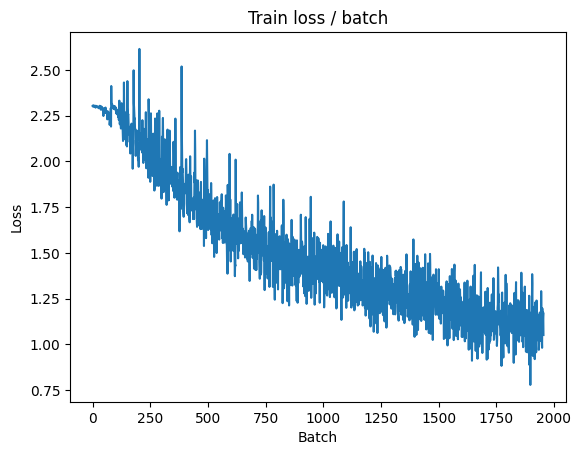

[TRAIN Batch 200/391]	Time 0.032s (0.023s)	Loss 0.8872 (1.0317)	Prec@1  68.8 ( 63.8)	Prec@5  96.9 ( 96.6)


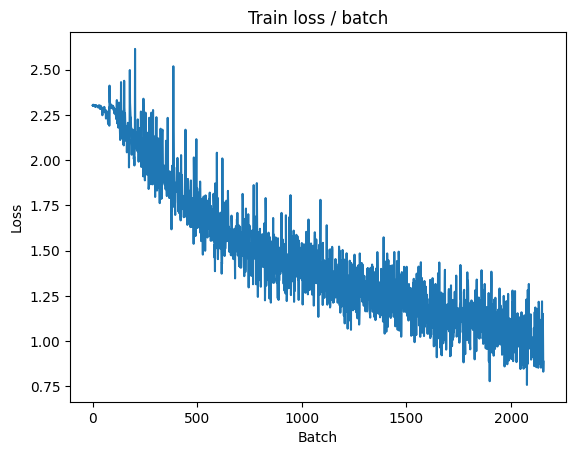


===============> Total time 8s	Avg loss 1.0137	Avg Prec@1 64.38 %	Avg Prec@5 96.73 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 1.0296 (1.0296)	Prec@1  66.4 ( 66.4)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.1431	Avg Prec@1 59.40 %	Avg Prec@5 95.80 %



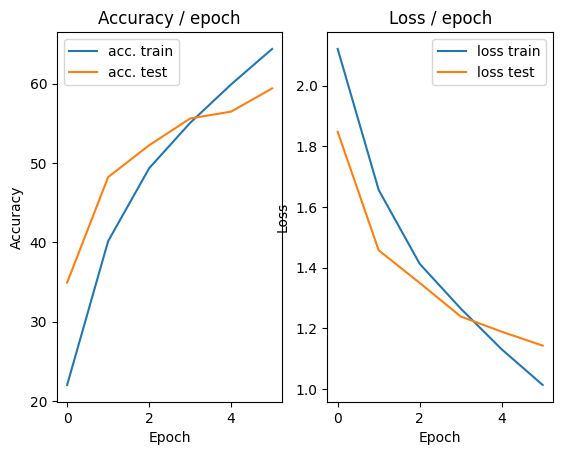

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.227s (0.227s)	Loss 0.9653 (0.9653)	Prec@1  68.0 ( 68.0)	Prec@5  93.8 ( 93.8)


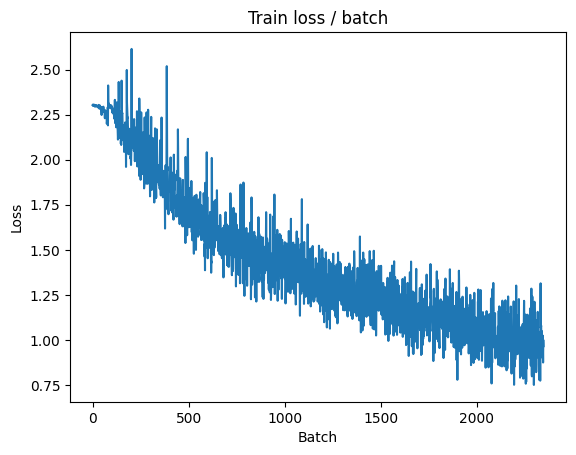

[TRAIN Batch 200/391]	Time 0.023s (0.028s)	Loss 1.1539 (0.9125)	Prec@1  64.1 ( 67.8)	Prec@5  95.3 ( 97.3)


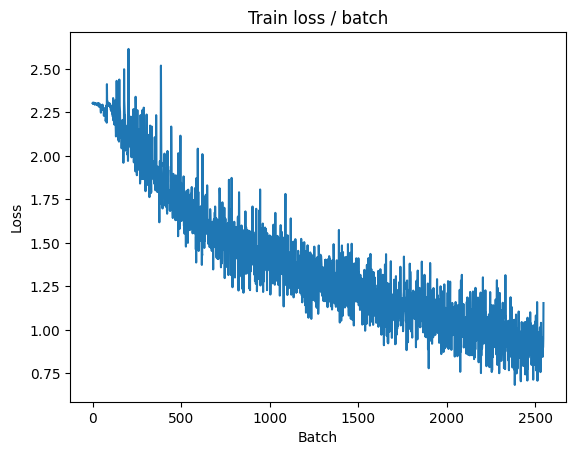


===============> Total time 9s	Avg loss 0.9037	Avg Prec@1 68.24 %	Avg Prec@5 97.39 %

[EVAL Batch 000/079]	Time 0.125s (0.125s)	Loss 1.0220 (1.0220)	Prec@1  68.0 ( 68.0)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0944	Avg Prec@1 62.25 %	Avg Prec@5 95.84 %



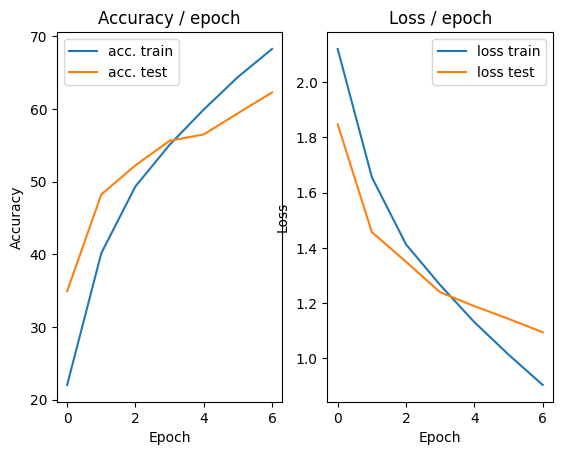

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.260s (0.260s)	Loss 0.9426 (0.9426)	Prec@1  68.0 ( 68.0)	Prec@5  96.1 ( 96.1)


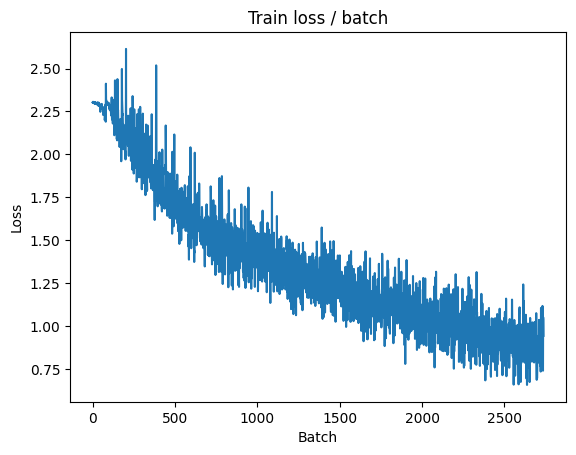

[TRAIN Batch 200/391]	Time 0.009s (0.032s)	Loss 0.8770 (0.8198)	Prec@1  66.4 ( 71.2)	Prec@5  97.7 ( 98.0)


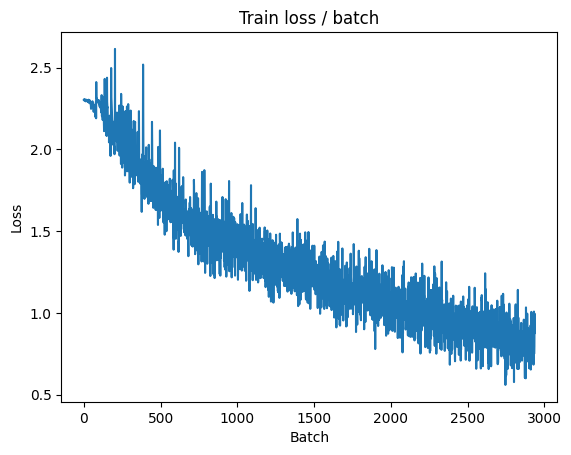


===============> Total time 10s	Avg loss 0.8076	Avg Prec@1 71.74 %	Avg Prec@5 98.04 %

[EVAL Batch 000/079]	Time 0.119s (0.119s)	Loss 0.9116 (0.9116)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.0101	Avg Prec@1 66.46 %	Avg Prec@5 96.64 %



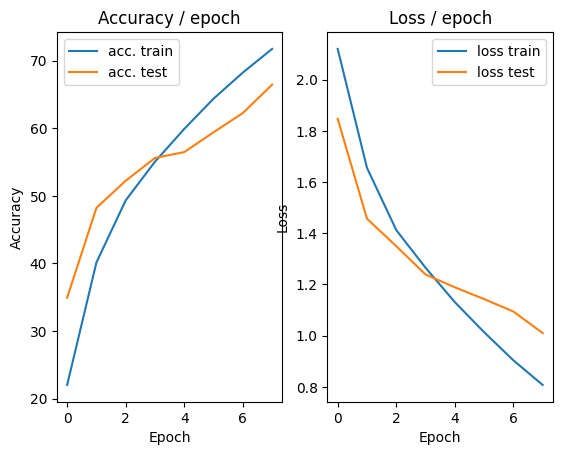

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.145s (0.145s)	Loss 0.8666 (0.8666)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)


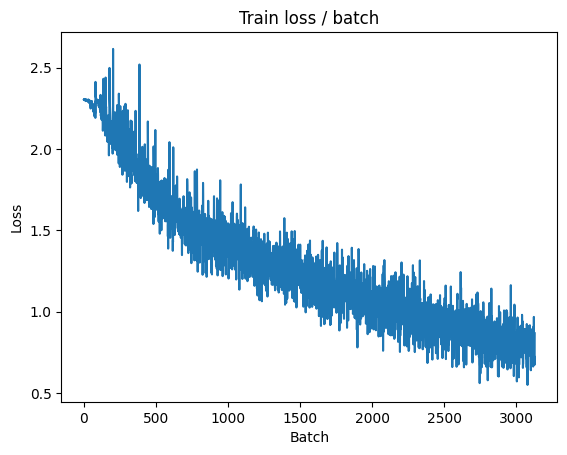

[TRAIN Batch 200/391]	Time 0.059s (0.031s)	Loss 0.7717 (0.6987)	Prec@1  72.7 ( 75.5)	Prec@5  98.4 ( 98.6)


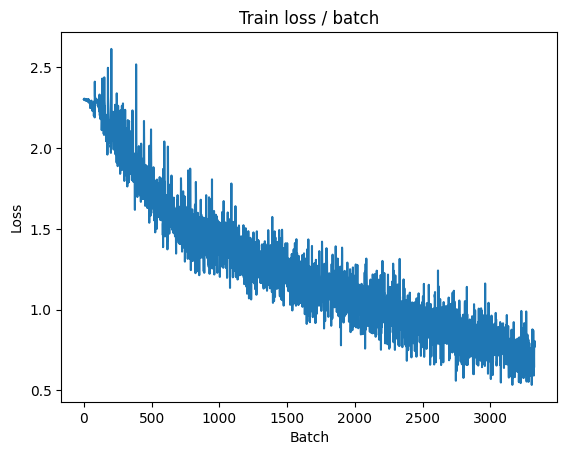


===============> Total time 10s	Avg loss 0.7056	Avg Prec@1 75.16 %	Avg Prec@5 98.60 %

[EVAL Batch 000/079]	Time 0.119s (0.119s)	Loss 1.0318 (1.0318)	Prec@1  69.5 ( 69.5)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.0218	Avg Prec@1 66.13 %	Avg Prec@5 96.73 %



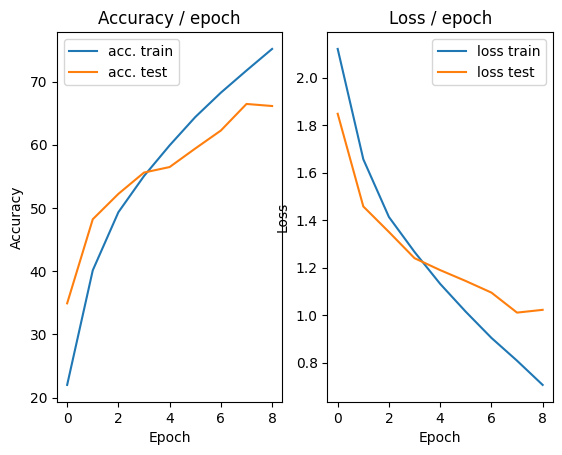

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.146s (0.146s)	Loss 0.8048 (0.8048)	Prec@1  68.0 ( 68.0)	Prec@5  98.4 ( 98.4)


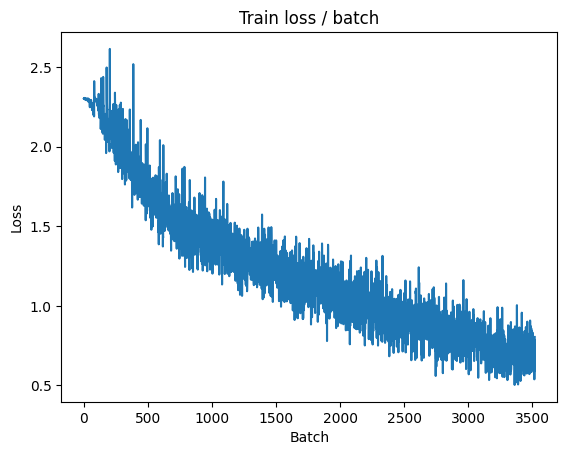

[TRAIN Batch 200/391]	Time 0.010s (0.028s)	Loss 0.5519 (0.6092)	Prec@1  78.9 ( 78.5)	Prec@5 100.0 ( 99.0)


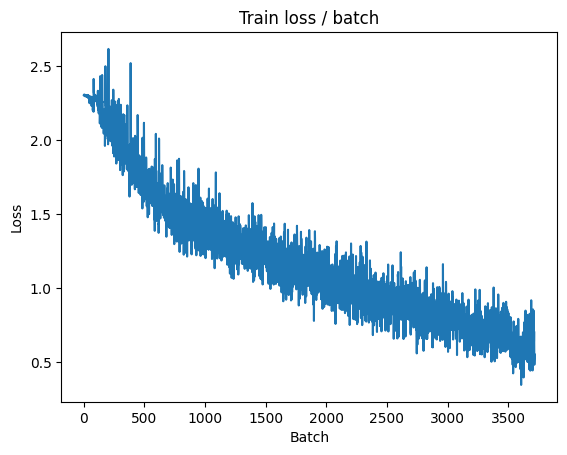


===============> Total time 9s	Avg loss 0.6133	Avg Prec@1 78.53 %	Avg Prec@5 98.95 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 1.0269 (1.0269)	Prec@1  64.1 ( 64.1)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.0416	Avg Prec@1 64.97 %	Avg Prec@5 96.61 %



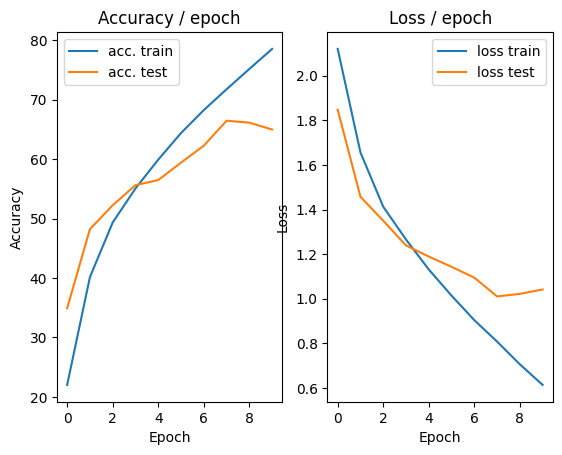

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.163s (0.163s)	Loss 0.6205 (0.6205)	Prec@1  80.5 ( 80.5)	Prec@5  98.4 ( 98.4)


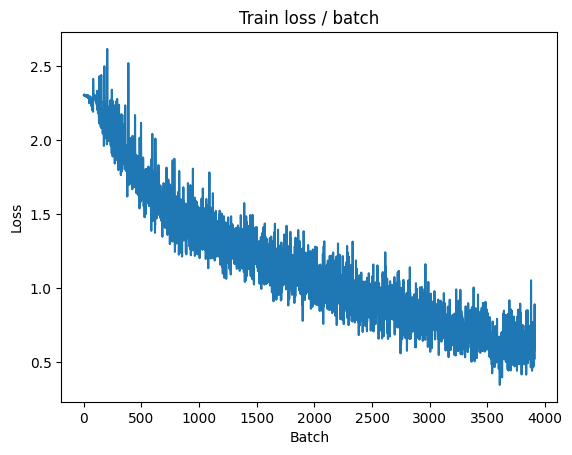

[TRAIN Batch 200/391]	Time 0.011s (0.028s)	Loss 0.4600 (0.5057)	Prec@1  83.6 ( 82.3)	Prec@5 100.0 ( 99.4)


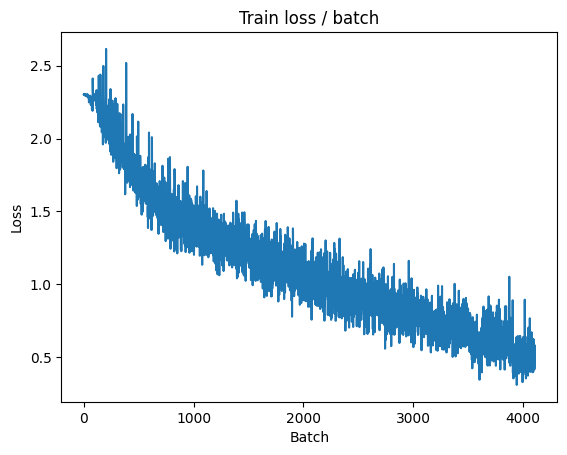


===============> Total time 9s	Avg loss 0.5223	Avg Prec@1 81.61 %	Avg Prec@5 99.32 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 1.0197 (1.0197)	Prec@1  65.6 ( 65.6)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.1806	Avg Prec@1 63.70 %	Avg Prec@5 96.80 %



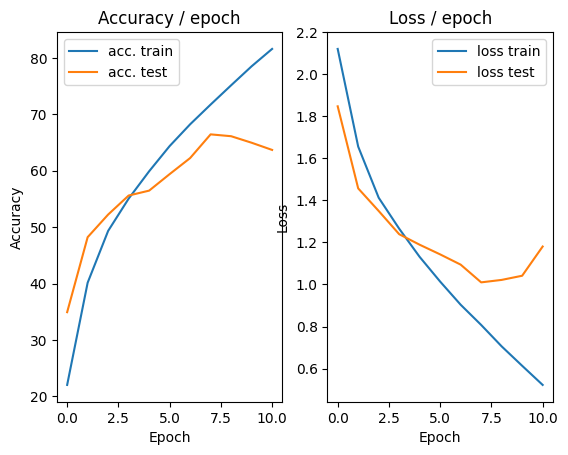

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.150s (0.150s)	Loss 0.5348 (0.5348)	Prec@1  82.0 ( 82.0)	Prec@5 100.0 (100.0)


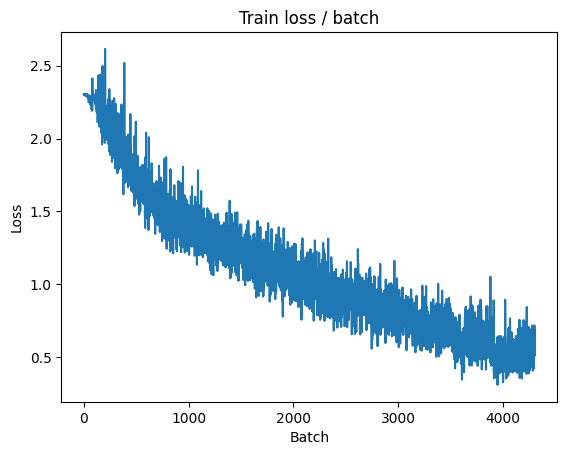

[TRAIN Batch 200/391]	Time 0.013s (0.024s)	Loss 0.4518 (0.4102)	Prec@1  86.7 ( 85.8)	Prec@5 100.0 ( 99.7)


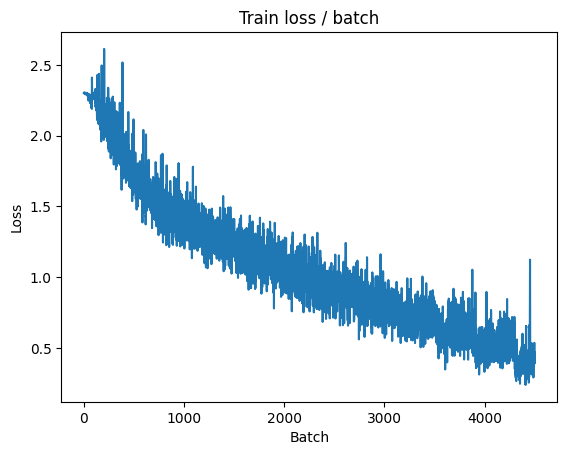


===============> Total time 9s	Avg loss 0.4290	Avg Prec@1 85.04 %	Avg Prec@5 99.63 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 1.0179 (1.0179)	Prec@1  71.9 ( 71.9)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0402	Avg Prec@1 68.67 %	Avg Prec@5 97.27 %



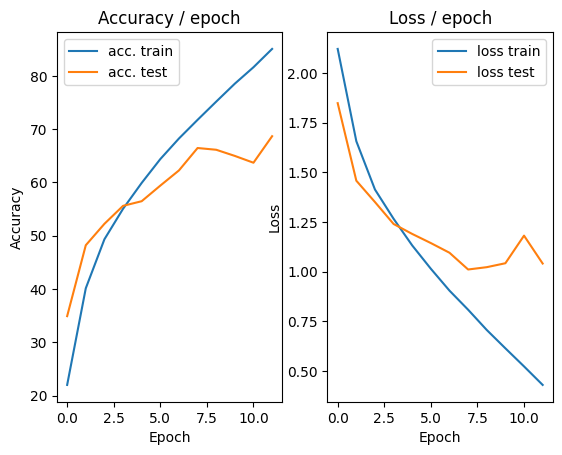

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 0.2511 (0.2511)	Prec@1  91.4 ( 91.4)	Prec@5 100.0 (100.0)


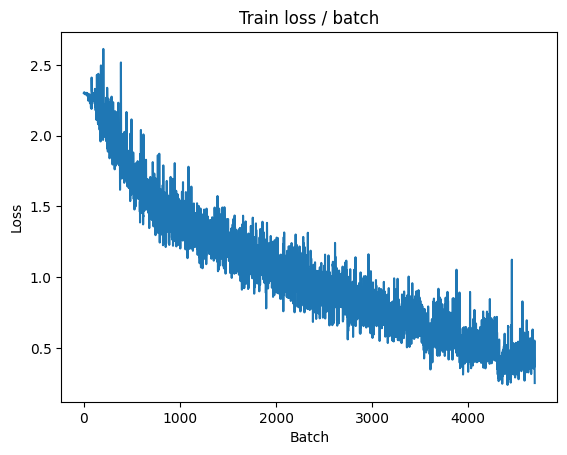

[TRAIN Batch 200/391]	Time 0.009s (0.022s)	Loss 0.3217 (0.3167)	Prec@1  86.7 ( 89.3)	Prec@5 100.0 ( 99.8)


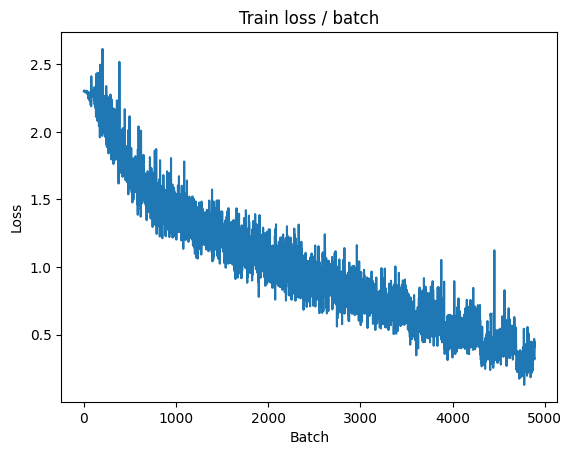


===============> Total time 9s	Avg loss 0.3350	Avg Prec@1 88.49 %	Avg Prec@5 99.80 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 1.2398 (1.2398)	Prec@1  71.9 ( 71.9)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.1724	Avg Prec@1 67.20 %	Avg Prec@5 96.86 %



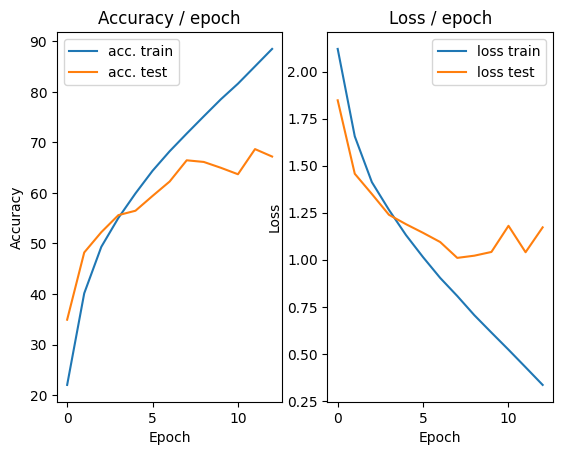

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.249s (0.249s)	Loss 0.2147 (0.2147)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


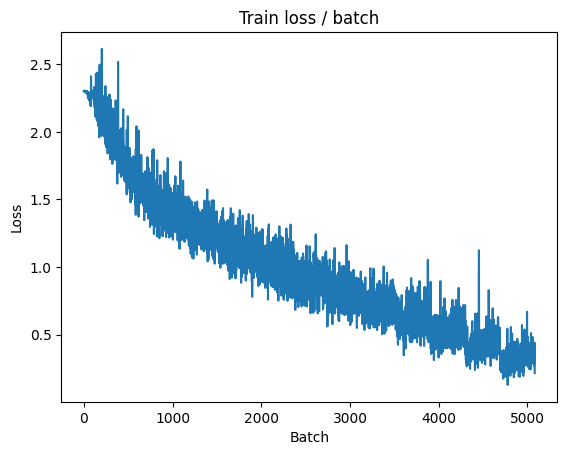

[TRAIN Batch 200/391]	Time 0.013s (0.040s)	Loss 0.3268 (0.2301)	Prec@1  89.1 ( 92.3)	Prec@5 100.0 ( 99.9)


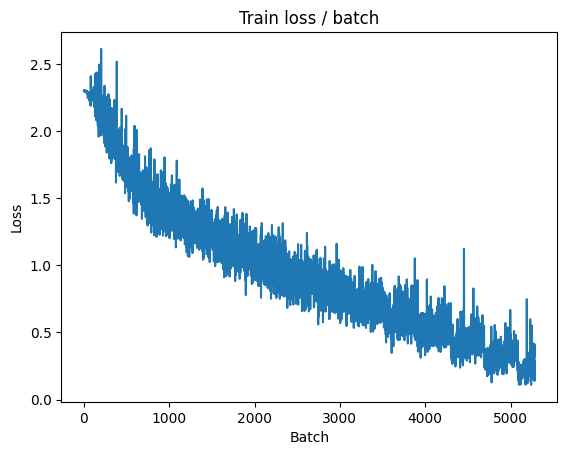


===============> Total time 12s	Avg loss 0.2487	Avg Prec@1 91.40 %	Avg Prec@5 99.92 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 1.2928 (1.2928)	Prec@1  68.8 ( 68.8)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.3251	Avg Prec@1 67.71 %	Avg Prec@5 96.56 %



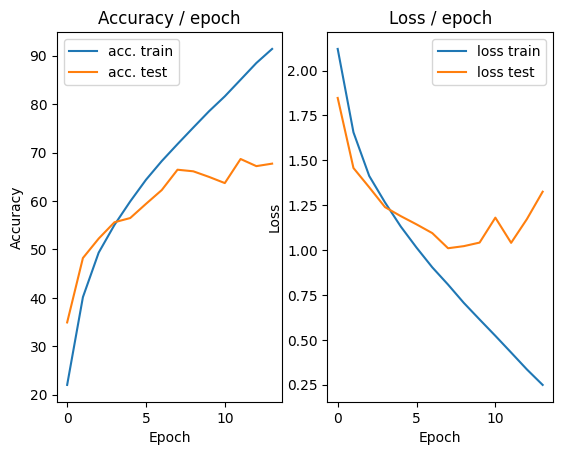

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.163s (0.163s)	Loss 0.3009 (0.3009)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


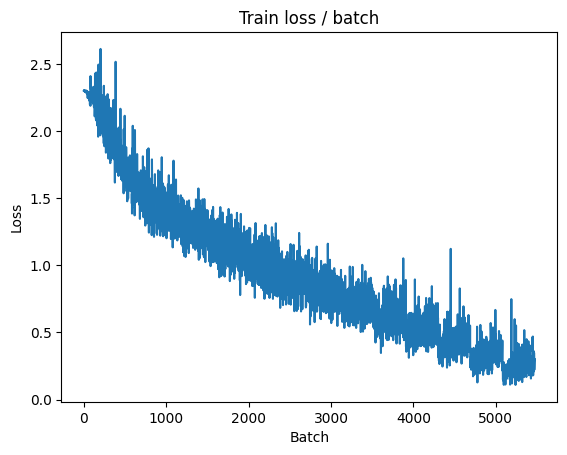

[TRAIN Batch 200/391]	Time 0.023s (0.025s)	Loss 0.2174 (0.1493)	Prec@1  91.4 ( 95.1)	Prec@5 100.0 (100.0)


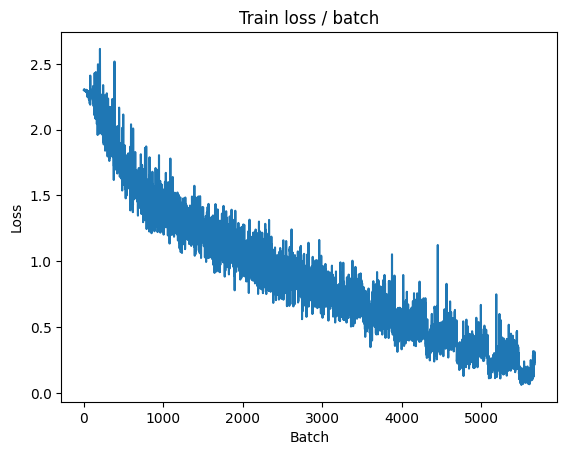


===============> Total time 9s	Avg loss 0.1782	Avg Prec@1 93.93 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 1.2725 (1.2725)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.3034	Avg Prec@1 68.54 %	Avg Prec@5 96.96 %



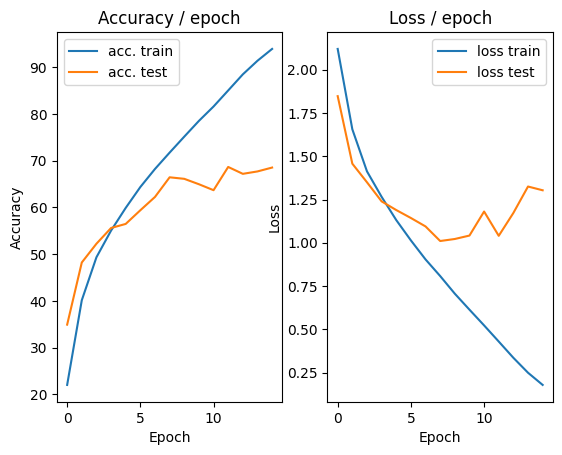

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.164s (0.164s)	Loss 0.0697 (0.0697)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


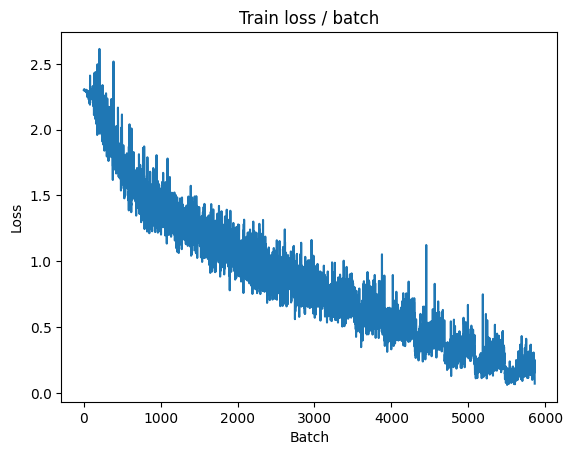

[TRAIN Batch 200/391]	Time 0.032s (0.023s)	Loss 0.0908 (0.1151)	Prec@1  96.9 ( 96.3)	Prec@5 100.0 (100.0)


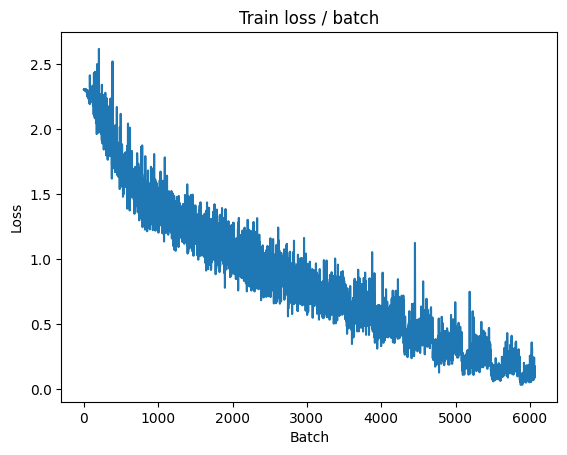


===============> Total time 9s	Avg loss 0.1301	Avg Prec@1 95.59 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 1.4563 (1.4563)	Prec@1  71.1 ( 71.1)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.4877	Avg Prec@1 67.57 %	Avg Prec@5 96.38 %



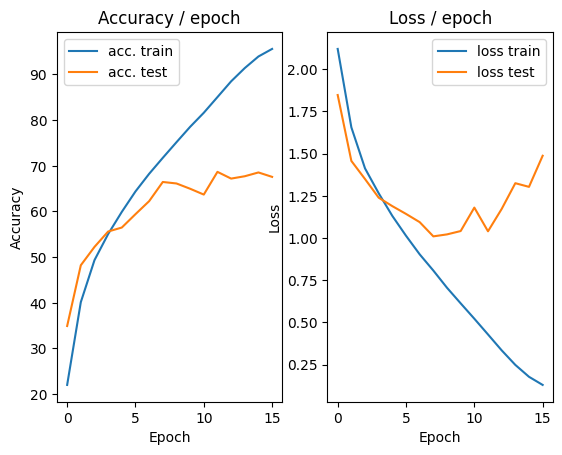

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.1081 (0.1081)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


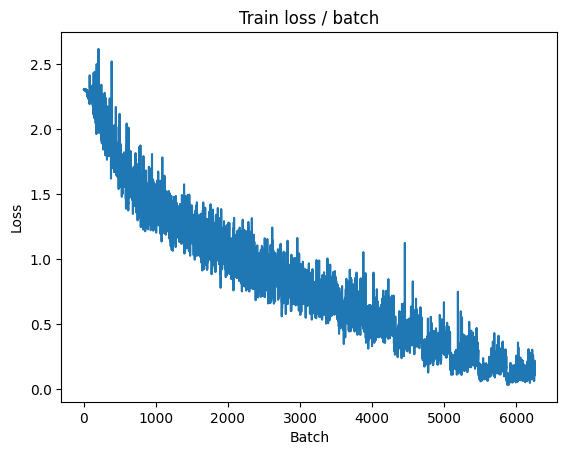

[TRAIN Batch 200/391]	Time 0.012s (0.023s)	Loss 0.0856 (0.0802)	Prec@1  96.9 ( 97.6)	Prec@5 100.0 (100.0)


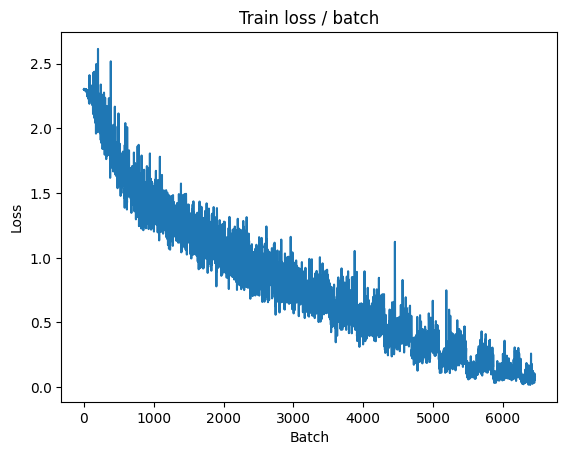


===============> Total time 9s	Avg loss 0.1012	Avg Prec@1 96.73 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.6179 (1.6179)	Prec@1  72.7 ( 72.7)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.5170	Avg Prec@1 68.71 %	Avg Prec@5 96.88 %



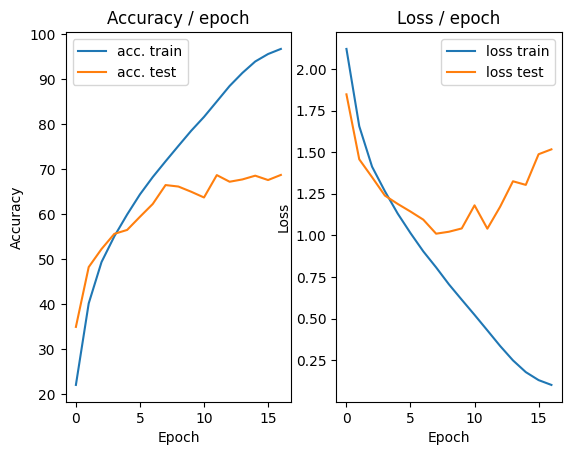

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.161s (0.161s)	Loss 0.0539 (0.0539)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


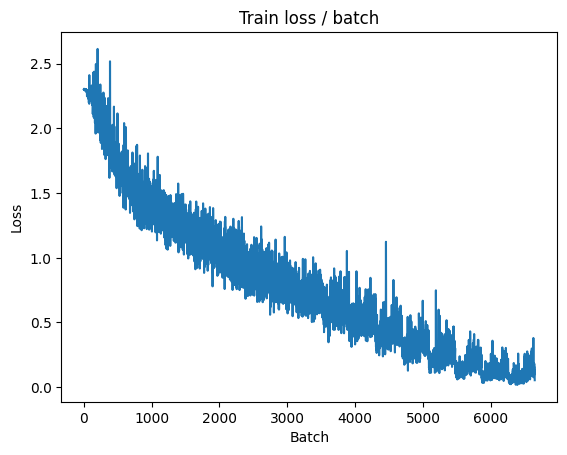

[TRAIN Batch 200/391]	Time 0.017s (0.022s)	Loss 0.0284 (0.0573)	Prec@1 100.0 ( 98.3)	Prec@5 100.0 (100.0)


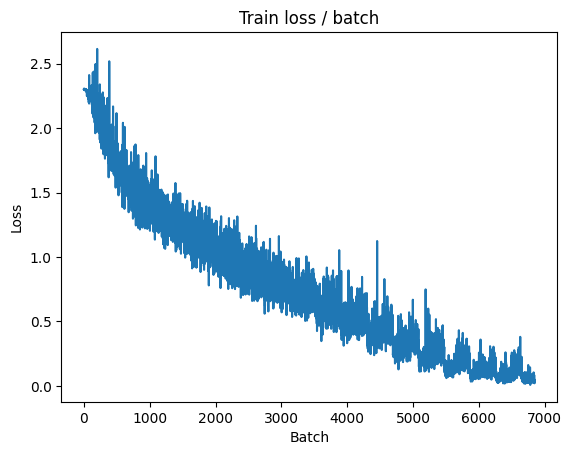


===============> Total time 9s	Avg loss 0.0655	Avg Prec@1 97.94 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.215s (0.215s)	Loss 1.8350 (1.8350)	Prec@1  69.5 ( 69.5)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.7426	Avg Prec@1 67.80 %	Avg Prec@5 96.85 %



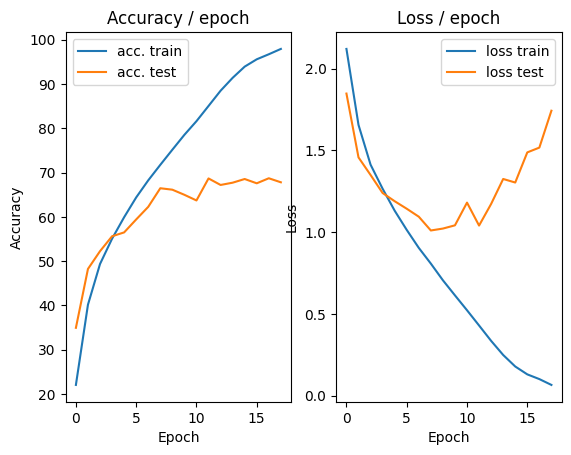

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.178s (0.178s)	Loss 0.1740 (0.1740)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


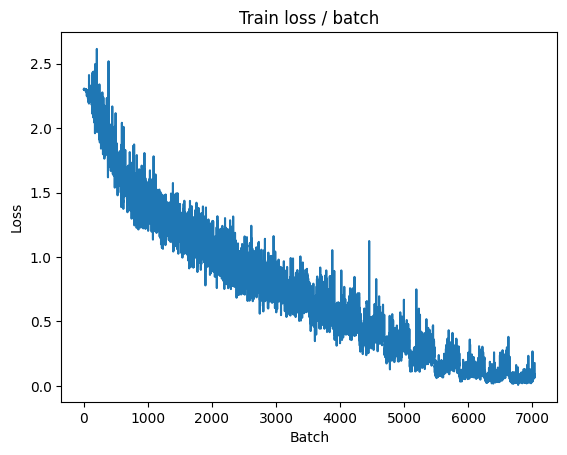

[TRAIN Batch 200/391]	Time 0.011s (0.022s)	Loss 0.0302 (0.0382)	Prec@1  99.2 ( 98.9)	Prec@5 100.0 (100.0)


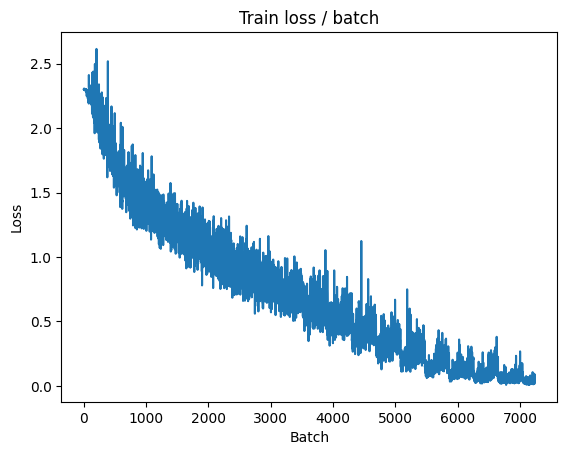


===============> Total time 10s	Avg loss 0.0654	Avg Prec@1 98.13 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.187s (0.187s)	Loss 1.3835 (1.3835)	Prec@1  75.0 ( 75.0)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.5641	Avg Prec@1 69.34 %	Avg Prec@5 97.06 %



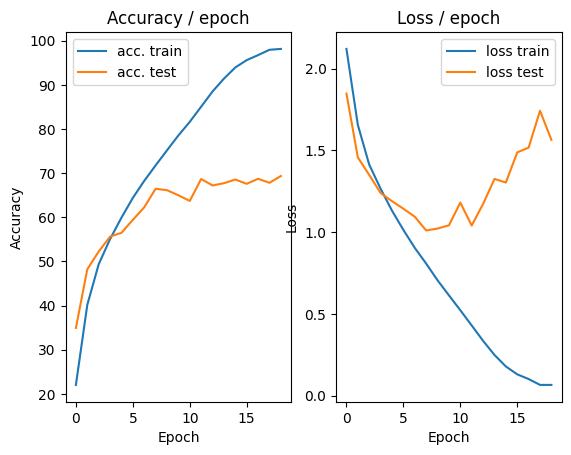

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 0.0185 (0.0185)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


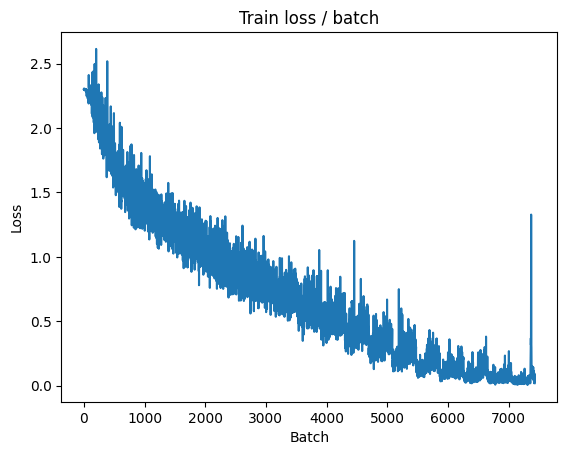

[TRAIN Batch 200/391]	Time 0.032s (0.022s)	Loss 0.0478 (0.0363)	Prec@1  98.4 ( 99.0)	Prec@5 100.0 (100.0)


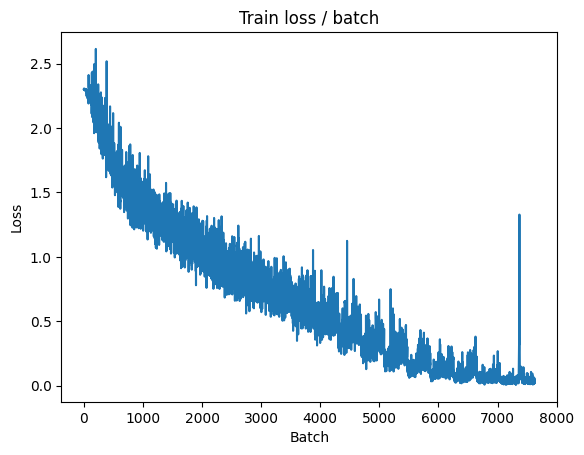


===============> Total time 8s	Avg loss 0.0396	Avg Prec@1 98.80 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 1.8835 (1.8835)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.8294	Avg Prec@1 69.09 %	Avg Prec@5 97.10 %



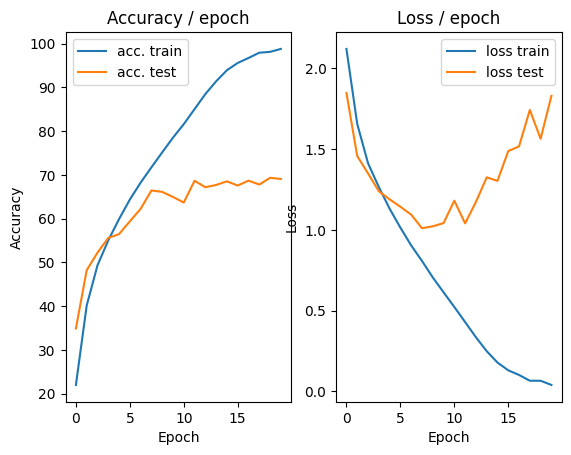

In [ ]:
 results_train, results_test = main(128, 0.1, epochs=20, cuda=True)

**After epoch 5, it starts to overfit.**

**Effects of learning rate**

In [12]:
learning_rates = [0.5, 0.02, 0.1, 0.05, 0.01, 0.001]

results = {}

for lr in learning_rates:
  print(f"Running with lr={lr}")
  results_train, results_test = main(128, lr, epochs=5,cuda=True,plotting=False,verbose=False)
  results[lr] = [results_train, results_test]

Running with lr=0.5
Files already downloaded and verified
Files already downloaded and verified

===============> Total time 10s	Avg loss 2.2996	Avg Prec@1 11.23 %	Avg Prec@5 52.76 %


===============> Total time 1s	Avg loss 2.3039	Avg Prec@1  9.96 %	Avg Prec@5 49.93 %


===============> Total time 9s	Avg loss 2.3036	Avg Prec@1  9.94 %	Avg Prec@5 49.92 %


===============> Total time 1s	Avg loss 2.2922	Avg Prec@1 15.80 %	Avg Prec@5 59.53 %


===============> Total time 9s	Avg loss 2.3122	Avg Prec@1 10.22 %	Avg Prec@5 50.72 %


===============> Total time 1s	Avg loss 2.3040	Avg Prec@1  9.98 %	Avg Prec@5 50.14 %


===============> Total time 11s	Avg loss 2.3030	Avg Prec@1 10.17 %	Avg Prec@5 50.52 %


===============> Total time 1s	Avg loss 2.3037	Avg Prec@1  9.89 %	Avg Prec@5 49.94 %


===============> Total time 9s	Avg loss 2.3031	Avg Prec@1 10.15 %	Avg Prec@5 50.06 %


===============> Total time 1s	Avg loss 2.3032	Avg Prec@1 10.10 %	Avg Prec@5 50.06 %

Running with lr=0.02
Files alrea

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

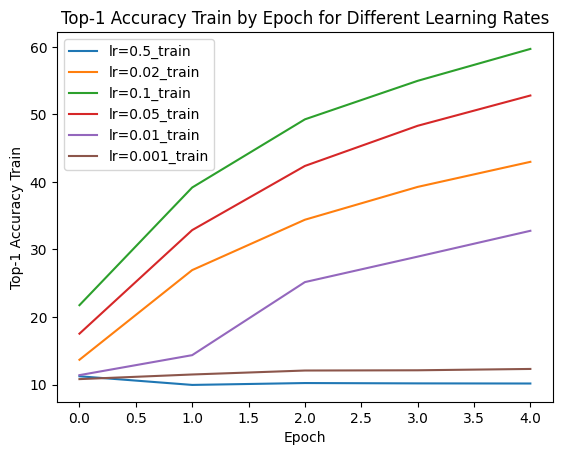

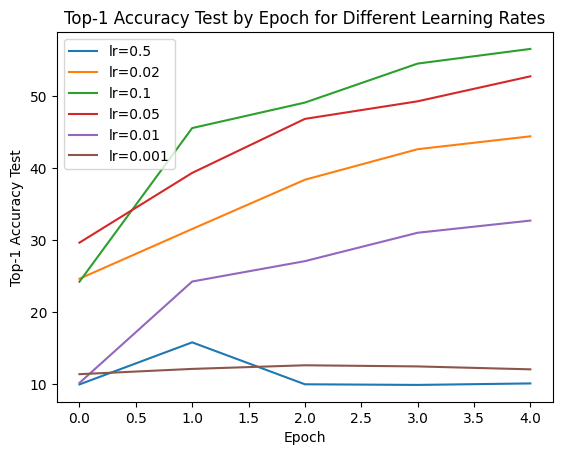

In [13]:
for lr, result in results.items():
  top1_acc_train_list = [epoch_results[0] for epoch_results in result[0].values()]
  plt.plot(range(len(top1_acc_train_list)), top1_acc_train_list, label=f"lr={lr}_train")

plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy Train")
plt.title("Top-1 Accuracy Train by Epoch for Different Learning Rates")
plt.legend()
plt.show()



for lr, result in results.items():
  top1_acc_test_list = [epoch_results[0] for epoch_results in result[1].values()]
  plt.plot(range(len(top1_acc_test_list)), top1_acc_test_list, label=f"lr={lr}")


plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy Test")
plt.title("Top-1 Accuracy Test by Epoch for Different Learning Rates")
plt.legend()
plt.show()



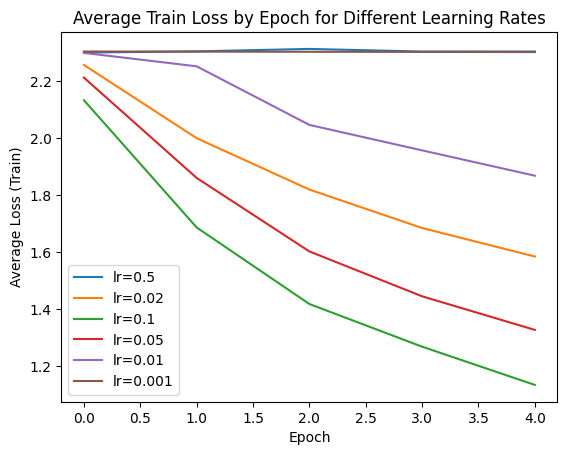

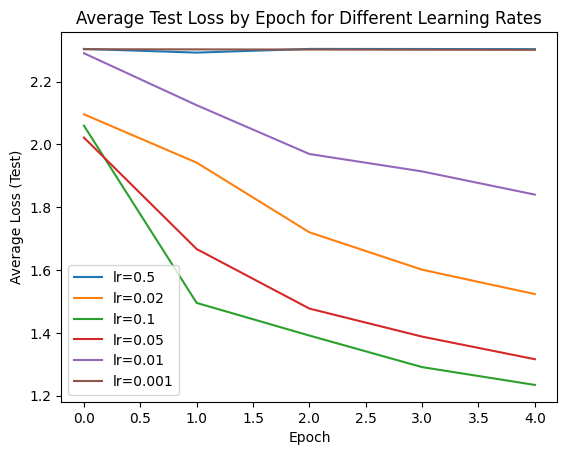

In [14]:
for lr, result in results.items():
  loss_train_list = [epoch_results[2] for epoch_results in result[0].values()]
  plt.plot(range(len(loss_train_list)), loss_train_list, label=f"lr={lr}")

plt.xlabel("Epoch")
plt.ylabel("Average Loss (Train)")
plt.title("Average Train Loss by Epoch for Different Learning Rates")
plt.legend()
plt.show()

for lr, result in results.items():
  loss_test_list = [epoch_results[2] for epoch_results in result[1].values()]
  plt.plot(range(len(loss_test_list)), loss_test_list, label=f"lr={lr}")

plt.xlabel("Epoch")
plt.ylabel("Average Loss (Test)")
plt.title("Average Test Loss by Epoch for Different Learning Rates")
plt.legend()
plt.show()

In [ ]:
# import pandas as pd
# lrs = []
# top1_accs = []
# loss_avgs = []

# for lr, result in results.items():
#   lrs.append(lr)
#   res = result[0]
#   lastkey = list(res.keys())[-1]
#   top1_accs.append(res[lastkey][0])
#   loss_avgs.append(res[lastkey][2])

# plt.figure(figsize=(8, 6))
# plt.plot(lrs, top1_accs, marker='o')
# plt.xlabel('Learning Rate')
# plt.ylabel('Top-1 Accuracy')
# plt.title('Top-1 Accuracy vs. Learning Rate')
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(lrs, loss_avgs, marker='o')
# plt.xlabel('Learning Rate')
# plt.ylabel('Average Loss')
# plt.title('Average Loss vs. Learning Rate')
# plt.grid(True)
# plt.show()

In [20]:
# table_data = {'Learning Rate': learning_rates, 'Top-1 Accuracy': top1_accs, 'Average Loss': loss_avgs}
# df = pd.DataFrame(table_data)
# df

Learning Rate  Top-1 Accuracy  Average Loss
0          0.500       10.153453      2.303074
1          0.020       42.978341      1.584299
2          0.100       59.697490      1.134074
3          0.050       52.798913      1.326999
4          0.010       32.766145      1.867693
5          0.001       12.309783      2.301249

In [21]:
best_lr = 0.1 #lrs[top1_accs.index(max(top1_accs))]
print(f"\nThe best learning rate is: {best_lr}")


The best learning rate is: 0.1


**Effects of batch sizes**

In [22]:
batch_sizes = [32,64,128,256]

results_batch = {}

for batch_size in batch_sizes:
  print(f"Running with batch size = {batch_size}")
  results_train, results_test = main(batch_size, best_lr, epochs=5,cuda=True,plotting=False,verbose=False)
  results_batch[batch_size] = [results_train, results_test]

Running with batch size = 32
Files already downloaded and verified
Files already downloaded and verified

===============> Total time 13s	Avg loss 1.7838	Avg Prec@1 34.54 %	Avg Prec@5 82.64 %


===============> Total time 2s	Avg loss 1.4083	Avg Prec@1 49.36 %	Avg Prec@5 92.44 %


===============> Total time 13s	Avg loss 1.2448	Avg Prec@1 55.66 %	Avg Prec@5 94.81 %


===============> Total time 3s	Avg loss 1.1089	Avg Prec@1 61.15 %	Avg Prec@5 95.97 %


===============> Total time 13s	Avg loss 1.0056	Avg Prec@1 64.55 %	Avg Prec@5 96.78 %


===============> Total time 2s	Avg loss 1.1035	Avg Prec@1 61.67 %	Avg Prec@5 95.48 %


===============> Total time 13s	Avg loss 0.8387	Avg Prec@1 70.70 %	Avg Prec@5 97.84 %


===============> Total time 2s	Avg loss 0.9797	Avg Prec@1 66.25 %	Avg Prec@5 96.64 %


===============> Total time 13s	Avg loss 0.6911	Avg Prec@1 75.88 %	Avg Prec@5 98.63 %


===============> Total time 2s	Avg loss 0.9446	Avg Prec@1 68.07 %	Avg Prec@5 97.08 %

Running with batch s

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

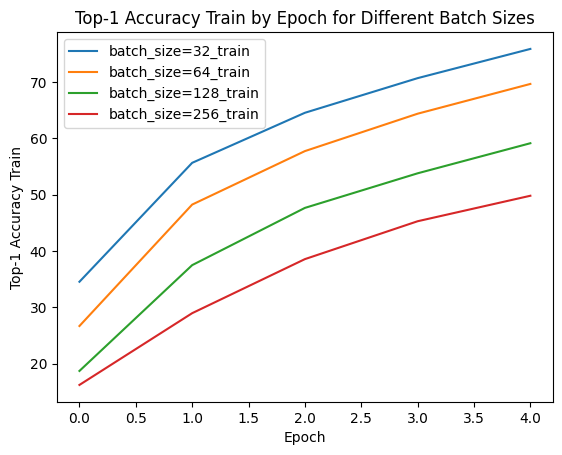

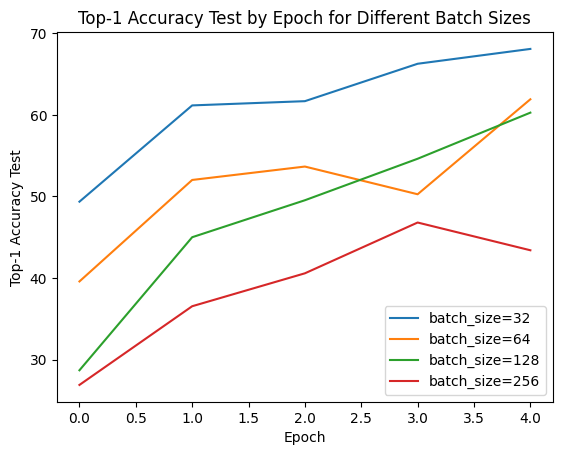

In [23]:
for bs, result in results_batch.items():
  top1_acc_train_list = [epoch_results[0] for epoch_results in result[0].values()]
  plt.plot(range(len(top1_acc_train_list)), top1_acc_train_list, label=f"batch_size={bs}_train")

plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy Train")
plt.title("Top-1 Accuracy Train by Epoch for Different Batch Sizes")
plt.legend()
plt.show()



for bs, result in results_batch.items():
  top1_acc_test_list = [epoch_results[0] for epoch_results in result[1].values()]
  plt.plot(range(len(top1_acc_test_list)), top1_acc_test_list, label=f"batch_size={bs}")


plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy Test")
plt.title("Top-1 Accuracy Test by Epoch for Different Batch Sizes")
plt.legend()
plt.show()



**3.1 Standardization**

In [ ]:
from torchvision.transforms import Lambda
from sklearn.decomposition import PCA

In [ ]:
# functions for different normalization methods

def l1_norm_func(img):
  """L1 normalization."""
  return img / torch.linalg.vector_norm(img, ord=1)

def min_max_norm_func(img):
  """Min-max normalization."""
  min = torch.min(img)
  max = torch.max(img)
  return img - min / max - min

def zca_whitening_func(img):
  """
  ZCA normalization.
  Algo followed from https://stackoverflow.com/questions/31528800/how-to-implement-zca-whitening-python
  and https://github.com/semi-supervised-paper/semi-supervised-paper-implementation/blob/e39b61ccab/semi_supervised/core/utils/data_util.py#L150
  """
  flat_img = img.view(img.size(0), -1)
  # zero centering
  mean = torch.mean(flat_img, dim=0, keepdim=True)
  centered_img = flat_img - mean

  cov_matrix = torch.cov(centered_img.T)
  U, S, V = torch.svd(cov_matrix) # SVD

  eps = 1e-5 # adding to prevent division by zero
  zca_matrix = torch.mm(U, torch.mm(torch.diag(1.0/torch.sqrt(S + eps)), U.T))

  whitened = torch.mm(centered_img, zca_matrix)
  whitened = whitened.view_as(img)

  #print("is zca_matrix square?", zca_matrix.size(0) == zca_matrix.size(1)) # already tested it's correct
  return whitened

def pca_whitening_func(img):
  """PCA whitening."""
  flat_img = img.reshape(-1, 3)

  # zero centering
  mean = flat_img.mean(axis=0)
  centered_img = flat_img - mean

  pca = PCA(whiten=True)
  whitened = pca.fit_transform(centered_img)

  whitened = whitened.reshape(img.shape) # reshape

  whitened_tensor = torch.from_numpy(whitened).float() # converting back to tensor
  return whitened_tensor

In [6]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

        )

        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False, normalization=None):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    transform = transforms.Compose([
            transforms.ToTensor()
        ])

    if normalization=='mean_std_normalization':
      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201])
      ])

    elif normalization=='l1_normalization':
      transform = transforms.Compose([
          transforms.ToTensor(),
          Lambda(l1_norm_func)

    ])

    elif normalization=='min_max_normalization':
        transform = transforms.Compose([
            transforms.ToTensor(),
            Lambda(min_max_norm_func)

      ])

    elif normalization=='zca_normalization':
        transform = transforms.Compose([
            transforms.ToTensor(),
            Lambda(zca_whitening_func)

      ])

    elif normalization=='pca_whitening':
        transform = transforms.Compose([
            transforms.ToTensor(),
            Lambda(lambda x: pca_whitening_func(x.numpy())),

      ])

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transform)

    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        #if i % PRINT_INTERVAL == 0:
        #    print('[{0:s} Batch {1:03d}/{2:03d}]\t'
        #           'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
         #         'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #          'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
        #          'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
        #           "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
        #           top1=avg_top1_acc, top5=avg_top5_acc))
        #    if optimizer:
        #        loss_plot.plot()

    # Print summary
    #print('\n===============> Total time {batch_time:d}s\t'
    #      'Avg loss {loss.avg:.4f}\t'
    #      'Avg Prec@1 {top1.avg:5.2f} %\t'
    #      'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
    #       batch_time=int(avg_batch_time.sum), loss=avg_loss,
    #       top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=10, cuda=False, normalization=None,plotting=True,verbose=True):


    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda, normalization)

    # init plots
    plot = AccLossPlot()
    #global loss_plot
    #loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda, verbose=verbose,plotting=plotting)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda,verbose=verbose,plotting=plotting)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


In [ ]:
# comparing different normalization methods

normalization_methods = [
    'mean_std_normalization',
    'l1_normalization',
    'min_max_normalization',
    #'zca_normalization', # ZCA is taking too long
    'pca_whitening'
]

batch_size=128
lr=0.1
epochs=10
cuda=True

# storing results for plotting
results = {method: {'loss_train': [], 'loss_test': [], 'acc_train': [], 'acc_test': []} for method in normalization_methods}


for normalization in normalization_methods:
  print(f"Running with {normalization}")

  model = ConvNet()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr)

  if cuda: # only with GPU, and not with CPU
      cudnn.benchmark = True
      model = model.cuda()
      criterion = criterion.cuda()

  # Get the data
  train, test = get_dataset(batch_size, cuda, normalization)

  for i in range(epochs):
    # Train phase
    top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
    # Test phase
    top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
    # plot
    results[normalization]['loss_train'].append(loss.avg)
    results[normalization]['loss_test'].append(loss_test.avg)
    results[normalization]['acc_train'].append(top1_acc.avg)
    results[normalization]['acc_test'].append(top1_acc_test.avg)

Running with mean_std_normalization
Files already downloaded and verified
Files already downloaded and verified
Running with l1_normalization
Files already downloaded and verified
Files already downloaded and verified
Running with min_max_normalization
Files already downloaded and verified
Files already downloaded and verified
Running with pca_whitening
Files already downloaded and verified
Files already downloaded and verified


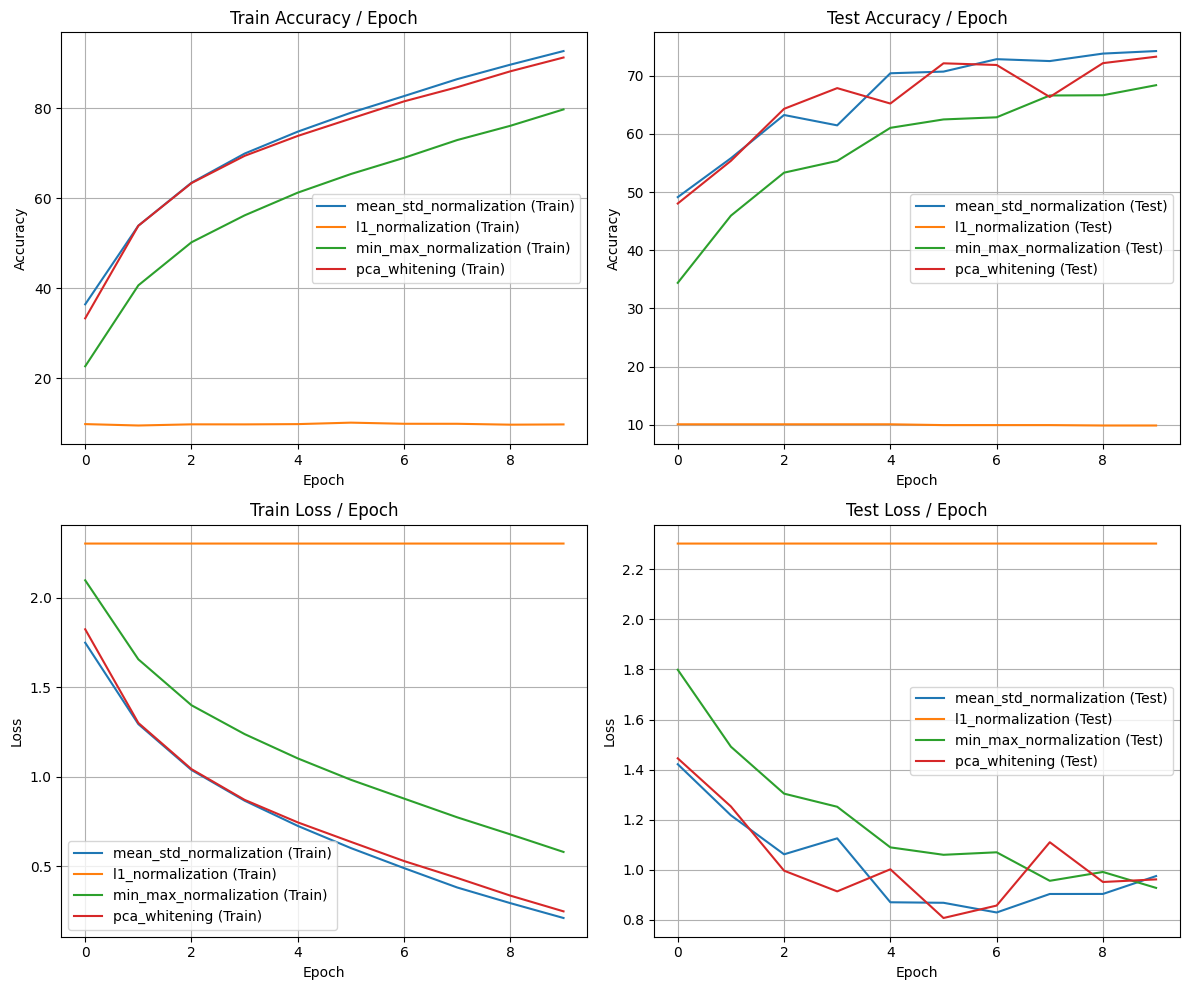

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Training Accuracy
for method in normalization_methods:
    axs[0, 0].plot(results[method]['acc_train'], label=f'{method} (Train)')
axs[0, 0].set_title('Train Accuracy / Epoch')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Test Accuracy
for method in normalization_methods:
    axs[0, 1].plot(results[method]['acc_test'], label=f'{method} (Test)')
axs[0, 1].set_title('Test Accuracy / Epoch')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()
axs[0, 1].grid()

# Training Loss
for method in normalization_methods:
    axs[1, 0].plot(results[method]['loss_train'], label=f'{method} (Train)')
axs[1, 0].set_title('Train Loss / Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()
axs[1, 0].grid()

# Test Loss
for method in normalization_methods:
    axs[1, 1].plot(results[method]['loss_test'], label=f'{method} (Test)')
axs[1, 1].set_title('Test Loss / Epoch')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid()

plt.tight_layout()
plt.show()

**3.2 Increase in the number of training examples**

In [7]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True ), # add ceil_mode=True

        )

        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False, normalization=None, augmentation=None):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    if augmentation=="augment": # (the method porposed in the TME instruction)
      train_transform = transforms.Compose([
          transforms.RandomCrop(28), # Random crop size 28
          transforms.RandomHorizontalFlip(),  # Random horizontal flip
          transforms.ToTensor(),

      ])

      test_transform = transforms.Compose([
          transforms.CenterCrop(28), # Centered crop of size 28
          transforms.ToTensor(),

      ])

    # not sure if we should do the transformations on the test set too?
    elif augmentation=="rotation":
      train_transform = transforms.Compose([
          transforms.RandomRotation(45),
          transforms.ToTensor(),
        ])

      test_transform = transforms.Compose([
          transforms.ToTensor(),

      ])

    elif augmentation=="gray_scale":
      train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),

      ])

      test_transform = transforms.Compose([
          transforms.ToTensor(),

      ])

    elif augmentation == "color_jitter":
      train_transform = transforms.Compose([
          transforms.ColorJitter(brightness=.5, hue=.3),
          transforms.ToTensor(),
      ])

      test_transform = transforms.Compose([
        transforms.ToTensor(),

      ])

    elif augmentation == "gaussian_blur":
      train_transform = transforms.Compose([
          transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
          transforms.ToTensor(),
      ])

      test_transform = transforms.Compose([
          transforms.ToTensor(),
      ])


    else:
      # no augmentation
      train_transform = transforms.Compose([
          transforms.ToTensor(),
      ])

      test_transform = transforms.Compose([
          transforms.ToTensor(),
      ])

    if normalization == 'mean_std_normalization':
        train_transform.transforms.append(transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]))
        test_transform.transforms.append(transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]))

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=train_transform)

    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

In [ ]:
# first just testing the augmentation method asked in the pdf instructions
# comparing no augmentation vs. augmentation

batch_size = 128
lr = 0.1
epochs = 10
cuda = True

res_augment = {
    'loss_train': [],
    'loss_test': [],
    'acc_train': [],
    'acc_test': []
}

res_no_augment = {
    'loss_train': [],
    'loss_test': [],
    'acc_train': [],
    'acc_test': []
}

def train_and_evaluate(normalization, results, augmentation=None):
    print(f"Running with {normalization}")

    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:  # Only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    train, test = get_dataset(batch_size, cuda, normalization, augmentation)


    for e in range(epochs):

        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

        # Store
        results['loss_train'].append(loss.avg)
        results['loss_test'].append(loss_test.avg)
        results['acc_train'].append(top1_acc.avg)
        results['acc_test'].append(top1_acc_test.avg)


    return results


# Run with data augmentation
train_and_evaluate(normalization='mean_std_normalization', results=res_augment, augmentation="augment")

# Run without data augmentation
train_and_evaluate(normalization='mean_std_normalization', results=res_no_augment, augmentation=None)

Running with mean_std_normalization
Files already downloaded and verified
Files already downloaded and verified
Running with mean_std_normalization
Files already downloaded and verified
Files already downloaded and verified


{'loss_train': [1.7341857343683462,
  1.270319832712793,
  1.046136395858072,
  0.8614437269127887,
  0.7289459509465396,
  0.6063383556997685,
  0.4920844355660021,
  0.38727234498314234,
  0.29009827990513626,
  0.21450667457697947],
 'loss_test': [1.3657412906236286,
  1.2140438141702097,
  1.030787935739831,
  0.936867226528216,
  0.9025365340558789,
  0.8938184901128842,
  0.8734612419635435,
  0.9078508970103686,
  1.0553012113027935,
  1.0224125008039837],
 'acc_train': [36.838634910485936,
  54.8349584398977,
  63.17455242966752,
  69.9792199488491,
  74.6875,
  78.77117966751918,
  82.69501278772378,
  86.57768542199489,
  89.80858375959079,
  92.5619405370844],
 'acc_test': [50.60324367088607,
  56.7939082278481,
  63.993275316455694,
  66.90071202531645,
  69.3631329113924,
  70.55973101265823,
  72.17167721518987,
  72.91337025316456,
  71.42009493670886,
  73.85284810126582]}

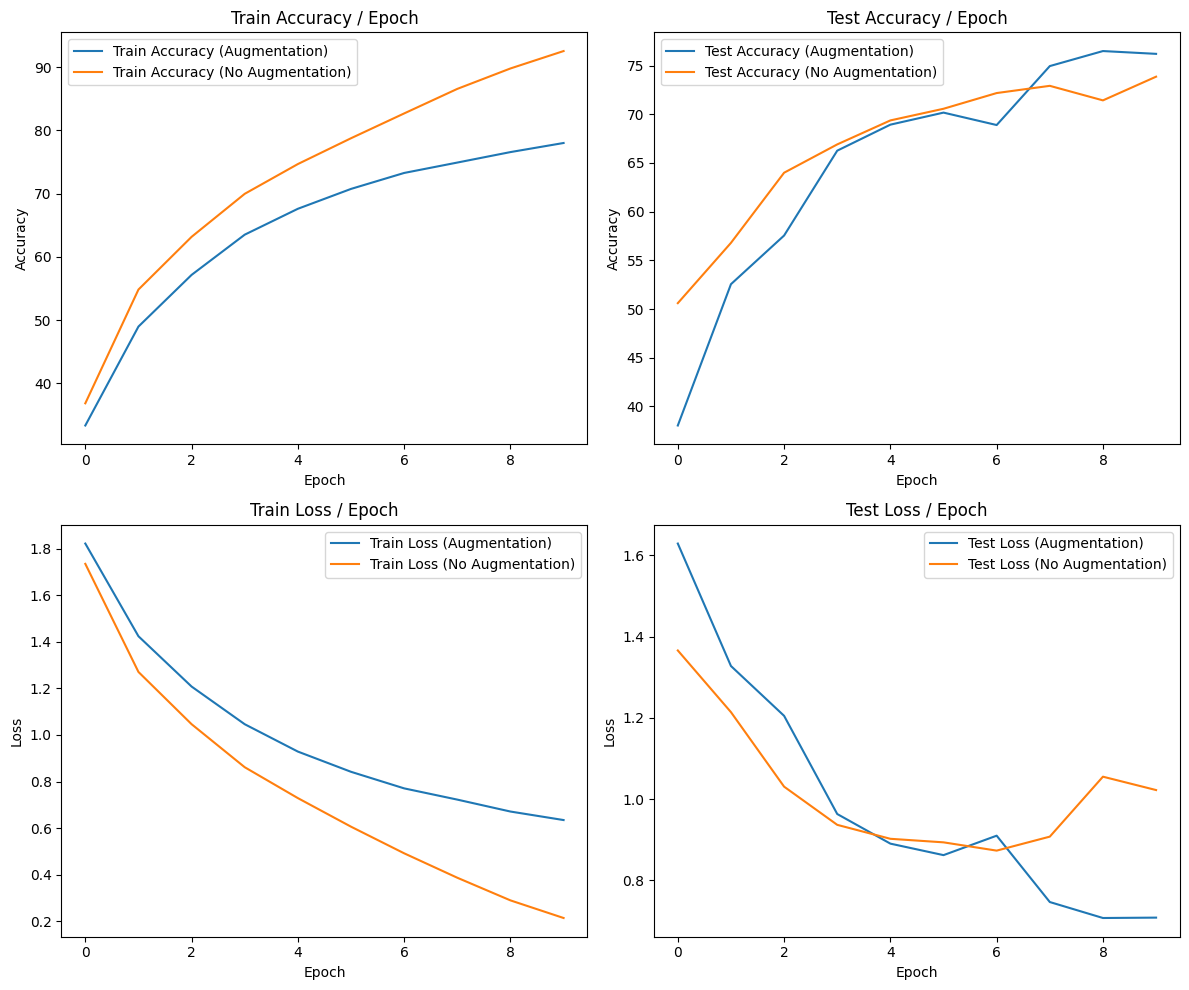

In [ ]:
# plotting to compare no augmentation vs. augmentation

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Training Accuracy
axs[0, 0].plot(res_augment['acc_train'], label=f'Train Accuracy (Augmentation)')
axs[0, 0].plot(res_no_augment['acc_train'], label=f'Train Accuracy (No Augmentation)')
axs[0, 0].set_title('Train Accuracy / Epoch')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Test Accuracy
axs[0, 1].plot(res_augment['acc_test'], label=f'Test Accuracy (Augmentation)')
axs[0, 1].plot(res_no_augment['acc_test'], label=f'Test Accuracy (No Augmentation)')
axs[0, 1].set_title('Test Accuracy / Epoch')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Training Loss
axs[1, 0].plot(res_augment['loss_train'], label=f'Train Loss (Augmentation)')
axs[1, 0].plot(res_no_augment['loss_train'], label=f'Train Loss (No Augmentation)')
axs[1, 0].set_title('Train Loss / Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Test Loss
axs[1, 1].plot(res_augment['loss_test'], label=f'Test Loss (Augmentation)')
axs[1, 1].plot(res_no_augment['loss_test'], label=f'Test Loss (No Augmentation)')
axs[1, 1].set_title('Test Loss / Epoch')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

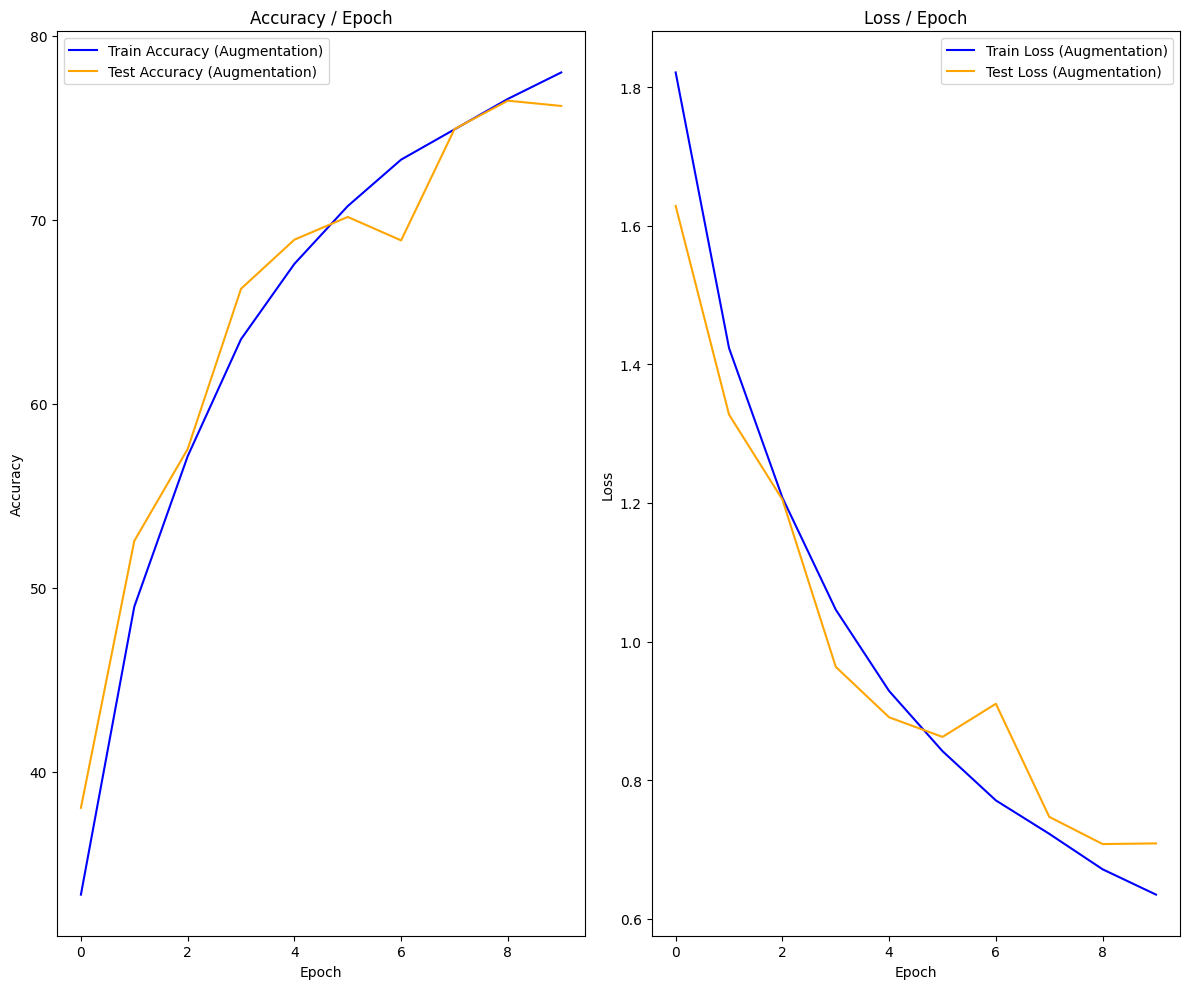

In [ ]:
# figure just showing the performance of data augmentation

fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# Accuracy
axs[0].plot(res_augment['acc_train'], label=f'Train Accuracy (Augmentation)', color='blue')
axs[0].plot(res_augment['acc_test'], label=f'Test Accuracy (Augmentation)', color='orange')
axs[0].set_title('Accuracy / Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(res_augment['loss_train'], label=f'Train Loss (Augmentation)', color='blue')
axs[1].plot(res_augment['loss_test'], label=f'Test Loss (Augmentation)', color='orange')
axs[1].set_title('Loss / Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

Now testing all the augmentation methods and no augmentation

In [8]:
def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    #global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        #if optimizer:
        #    loss_plot.update(avg_loss.val)
        # print info
        #if i % PRINT_INTERVAL == 0:
        #    print('[{0:s} Batch {1:03d}/{2:03d}]\t'
        #           'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
         #         'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #          'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
        #          'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
        #           "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
        #           top1=avg_top1_acc, top5=avg_top5_acc))
        #    if optimizer:
        #        loss_plot.plot()

    # Print summary
    #print('\n===============> Total time {batch_time:d}s\t'
    #      'Avg loss {loss.avg:.4f}\t'
    #      'Avg Prec@1 {top1.avg:5.2f} %\t'
    #      'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
    #       batch_time=int(avg_batch_time.sum), loss=avg_loss,
    #       top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

In [ ]:
# we use mean_std_normalization in all cases

batch_size = 128
lr = 0.1
epochs = 10
cuda=True

augmentations = [None, "augment", "rotation", "gray_scale", "color_jitter", "gaussian_blur"]
results = {}

for aug in augmentations:
    print(f"Running with augmentation: {aug}")

    train, test = get_dataset(batch_size=batch_size, cuda=cuda, normalization='mean_std_normalization', augmentation=aug)

    model = ConvNet().cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    results[aug] = {
        "acc_train": [],
        "acc_test": [],
        "loss_train": [],
        "loss_test": []
    }

    for i in range(epochs):
      # Train phase
      top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
      # Test phase
      top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
      # plot
      results[aug]['loss_train'].append(loss.avg)
      results[aug]['loss_test'].append(loss_test.avg)
      results[aug]['acc_train'].append(top1_acc.avg)
      results[aug]['acc_test'].append(top1_acc_test.avg)


Running with augmentation: None
Files already downloaded and verified
Files already downloaded and verified
Running with augmentation: augment
Files already downloaded and verified
Files already downloaded and verified
Running with augmentation: rotation
Files already downloaded and verified
Files already downloaded and verified
Running with augmentation: gray_scale
Files already downloaded and verified
Files already downloaded and verified
Running with augmentation: color_jitter
Files already downloaded and verified
Files already downloaded and verified
Running with augmentation: gaussian_blur
Files already downloaded and verified
Files already downloaded and verified


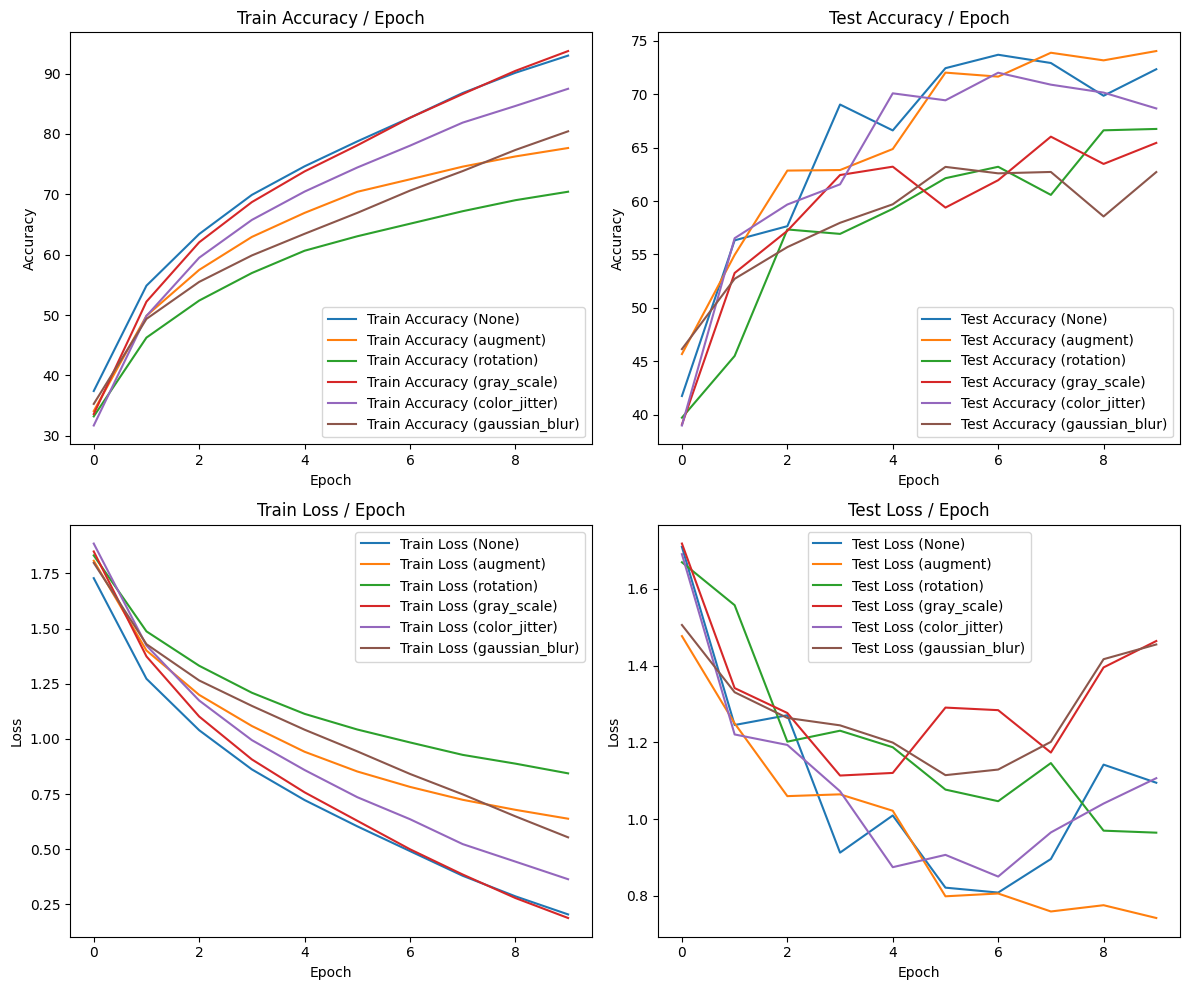

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))


# Training Accuracy
for aug in augmentations:
    axs[0, 0].plot(results[aug]['acc_train'], label=f'Train Accuracy ({aug})')
axs[0, 0].set_title('Train Accuracy / Epoch')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Test Accuracy
for aug in augmentations:
    axs[0, 1].plot(results[aug]['acc_test'], label=f'Test Accuracy ({aug})')
axs[0, 1].set_title('Test Accuracy / Epoch')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Training Loss
for aug in augmentations:
    axs[1, 0].plot(results[aug]['loss_train'], label=f'Train Loss ({aug})')
axs[1, 0].set_title('Train Loss / Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Test Loss
for aug in augmentations:
    axs[1, 1].plot(results[aug]['loss_test'], label=f'Test Loss ({aug})')
axs[1, 1].set_title('Test Loss / Epoch')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

3.3

In [ ]:
# Import the package
import torch.optim.lr_scheduler

def train_and_evaluate_scheduled(model,criterion,optimizer,results,sched=torch.optim.lr_scheduler.ExponentialLR,sched_params={"gamma": 0.95},epochs=10,cuda=True):

    #model = ConvNet()
    #criterion = nn.CrossEntropyLoss()
    opt = optimizer(model.parameters(), lr)
    lr_sched = sched(opt,**sched_params)


    if cuda:  # Only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    train, test = get_dataset2(datasets.CIFAR10,batch_size, cuda)


    for e in range(epochs):

        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, opt, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        lr_sched.step()

        # Store
        results['loss_train'].append(loss.avg)
        results['loss_test'].append(loss_test.avg)
        results['acc_train'].append(top1_acc.avg)
        results['acc_test'].append(top1_acc_test.avg)


    return results

In [ ]:
batch_size = 128
lr = 0.1
epochs = 10
cuda = True
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD

results = {
        "acc_train": [],
        "acc_test": [],
        "loss_train": [],
        "loss_test": []
    }
train_and_evaluate_scheduled(model,criterion,optimizer,results,cuda=cuda)



Files already downloaded and verified
Files already downloaded and verified


{'acc_train': [23.69365409207161,
  41.98209718670077,
  50.553468670076725,
  55.98105818414322,
  61.013826726342714,
  65.20540281329923,
  69.01174872122762,
  71.96691176470588,
  75.47354539641944,
  78.4167199488491],
 'acc_test': [34.6123417721519,
  48.2001582278481,
  53.708465189873415,
  56.71479430379747,
  61.50118670886076,
  60.16613924050633,
  64.5371835443038,
  66.39636075949367,
  61.79786392405063,
  66.53481012658227],
 'loss_train': [2.0821300507201563,
  1.6163969735050445,
  1.3840503902996288,
  1.2390652353806264,
  1.106126396247493,
  0.9865648062027934,
  0.8864963120206848,
  0.7963261002164972,
  0.7005692631234903,
  0.6176522570802733],
 'loss_test': [1.854746483549287,
  1.4549361437181882,
  1.2786148907263069,
  1.2161236028128033,
  1.0869305352621441,
  1.1157824087746535,
  1.006287045116666,
  0.9631764805769618,
  1.1070416501805753,
  0.9807276506967182]}

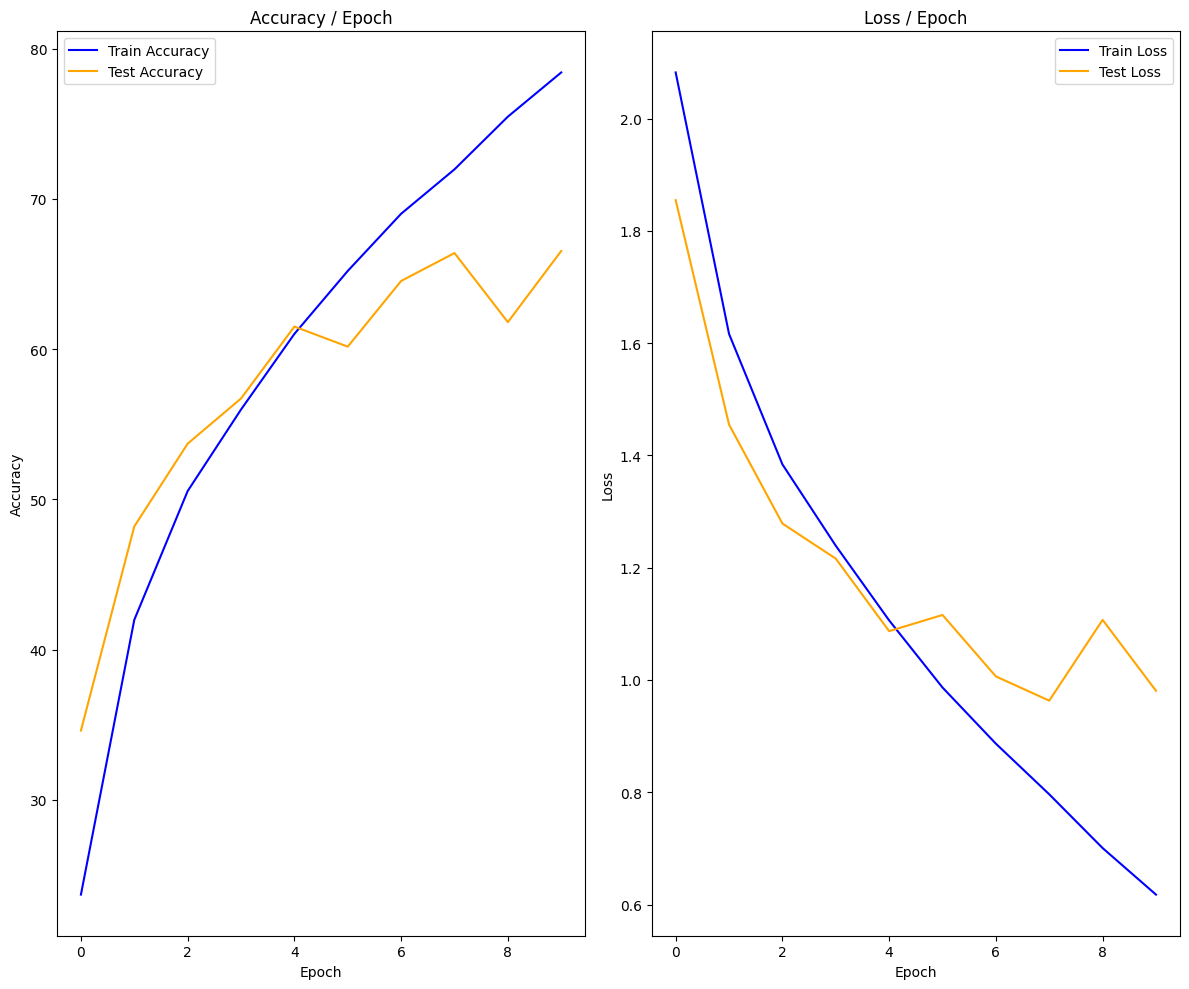

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# Accuracy
axs[0].plot(results['acc_train'], label=f'Train Accuracy', color='blue')
axs[0].plot(results['acc_test'], label=f'Test Accuracy', color='orange')
axs[0].set_title('Accuracy / Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(results['loss_train'], label=f'Train Loss', color='blue')
axs[1].plot(results['loss_test'], label=f'Test Loss', color='orange')
axs[1].set_title('Loss / Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# adding to see performance of the network without lr scheduler to compare

batch_size = 128
lr = 0.1
epochs = 10
cuda = True

res_simple = {
    'loss_train': [],
    'loss_test': [],
    'acc_train': [],
    'acc_test': []
}

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD

def train_and_evaluate2(model, criterion, optimizer, results) :
    opt = optimizer(model.parameters(), lr)

    if cuda:  # Only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    train, test = get_dataset2(datasets.CIFAR10,batch_size, cuda)

    for e in range(epochs):

        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, opt, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

        # Store
        results['loss_train'].append(loss.avg)
        results['loss_test'].append(loss_test.avg)
        results['acc_train'].append(top1_acc.avg)
        results['acc_test'].append(top1_acc_test.avg)

    return results

train_and_evaluate2(model, criterion, optimizer, res_simple)

Files already downloaded and verified
Files already downloaded and verified


{'loss_train': [2.0722005928263947,
  1.6428657608568822,
  1.408029008094612,
  1.2572677877857863,
  1.1106084390064639,
  0.9918263351825802,
  0.8831676878892553,
  0.7883726530672645,
  0.6869003687368329,
  0.589843999546812],
 'loss_test': [1.7818214229390592,
  1.5095929933499685,
  1.304025152061559,
  1.2062125055095818,
  1.246085213709481,
  1.0742092026939876,
  1.204360774046258,
  0.9024099798142156,
  0.966568544695649,
  0.9592292082460621],
 'acc_train': [24.095668158567776,
  40.88714833759591,
  49.59119245524297,
  55.33847506393862,
  60.859974424552426,
  65.28852301790282,
  68.92862851662404,
  72.39889705882354,
  76.04699488491049,
  79.27070012787723],
 'acc_test': [32.80261075949367,
  45.53006329113924,
  53.13488924050633,
  57.169699367088604,
  56.20055379746835,
  61.51107594936709,
  59.92879746835443,
  68.9181170886076,
  67.83030063291139,
  68.30498417721519]}

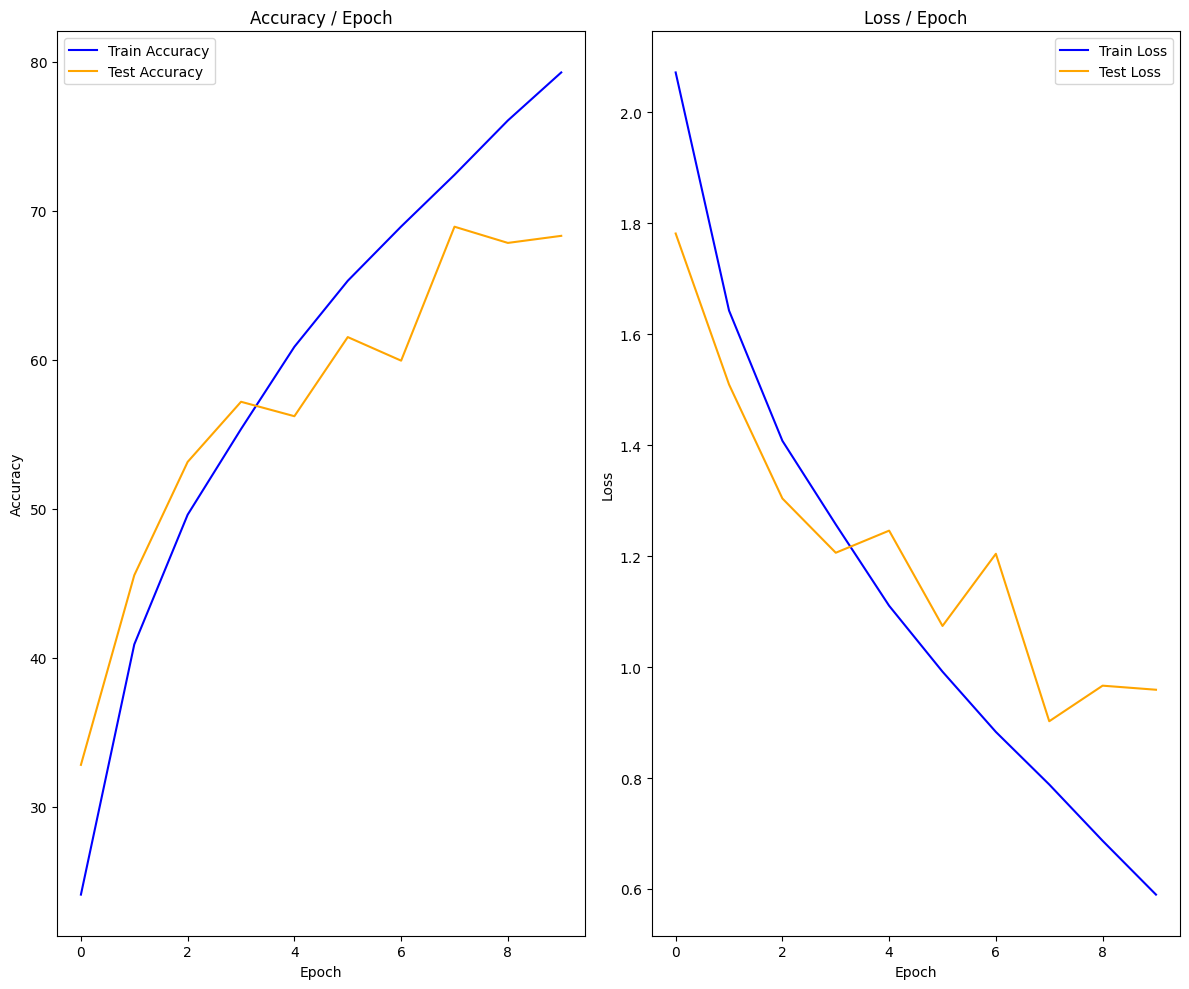

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# Accuracy
axs[0].plot(res_simple['acc_train'], label=f'Train Accuracy', color='blue')
axs[0].plot(res_simple['acc_test'], label=f'Test Accuracy', color='orange')
axs[0].set_title('Accuracy / Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(res_simple['loss_train'], label=f'Train Loss', color='blue')
axs[1].plot(res_simple['loss_test'], label=f'Test Loss', color='orange')
axs[1].set_title('Loss / Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# RERUN THIS BCS ADAMAX/RMSPROP/RPROP ARE ADDED LATER

In [ ]:
#testing different sgd variants

sgd_variants = [
    torch.optim.SGD,
    torch.optim.ASGD,
    torch.optim.Adadelta,
    torch.optim.Adagrad,
    torch.optim.Adam,
    torch.optim.AdamW,
    torch.optim.Adamax,
    torch.optim.RMSprop,
    torch.optim.Rprop
]
results = {}

for variant in sgd_variants:
    print(f"Running with variant: {variant.__name__}")

    #train, test = get_dataset(batch_size=64, cuda=True, normalization='mean_std_normalization')

    model = ConvNet().cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = variant
    cuda = True
    results[variant.__name__] = {
        "acc_train": [],
        "acc_test": [],
        "loss_train": [],
        "loss_test": []
    }

    train_and_evaluate_scheduled(model,criterion,optimizer,results[variant.__name__] ,cuda=cuda)




Running with variant: SGD
Files already downloaded and verified
Files already downloaded and verified
Running with variant: ASGD
Files already downloaded and verified
Files already downloaded and verified
Running with variant: Adadelta
Files already downloaded and verified
Files already downloaded and verified
Running with variant: Adagrad
Files already downloaded and verified
Files already downloaded and verified
Running with variant: Adam
Files already downloaded and verified
Files already downloaded and verified
Running with variant: AdamW
Files already downloaded and verified
Files already downloaded and verified
Running with variant: Adamax
Files already downloaded and verified
Files already downloaded and verified
Running with variant: RMSprop
Files already downloaded and verified
Files already downloaded and verified
Running with variant: Rprop
Files already downloaded and verified
Files already downloaded and verified


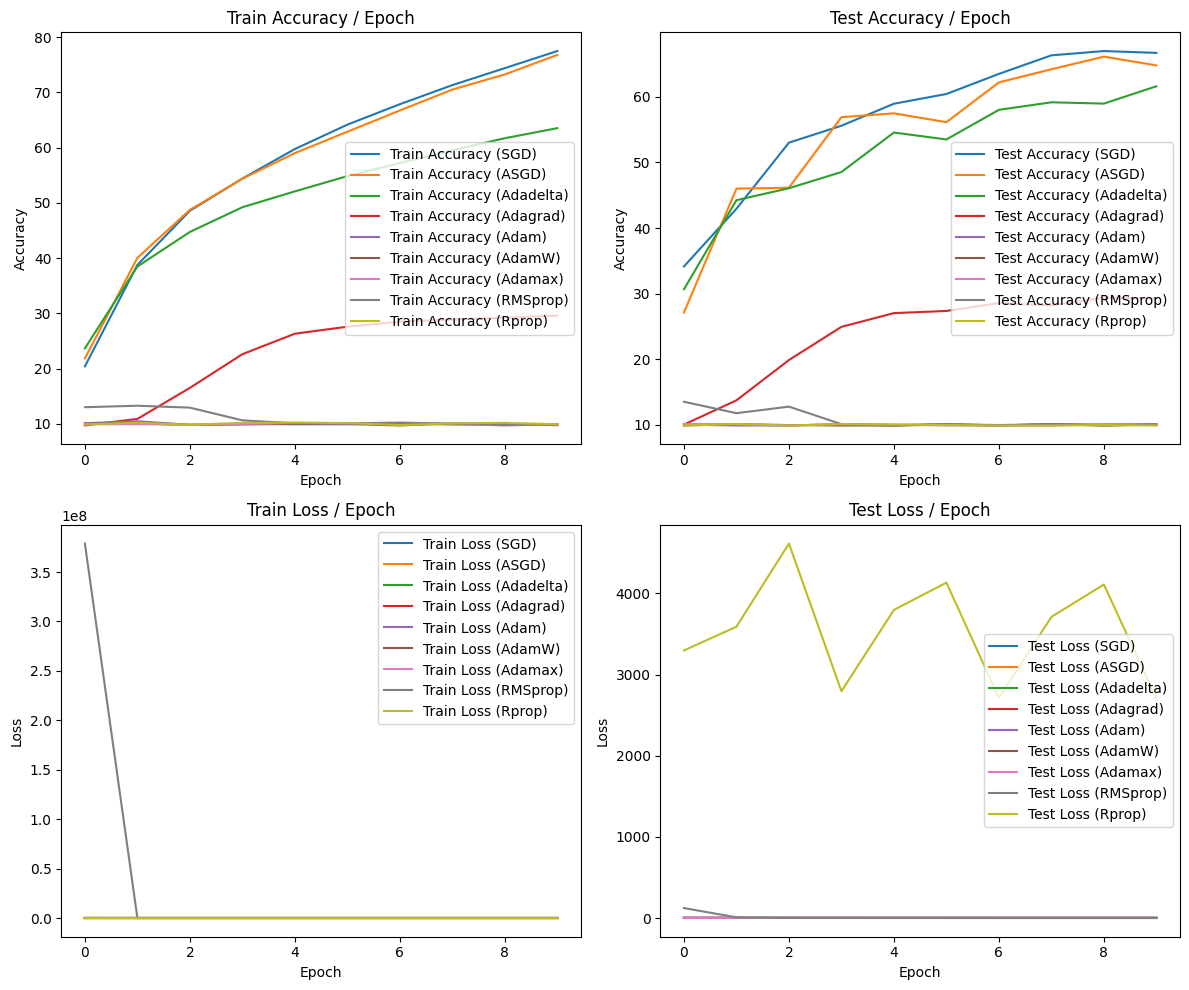

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Training Accuracy
for variant in sgd_variants:
    axs[0, 0].plot(results[variant.__name__]['acc_train'], label=f'Train Accuracy ({variant.__name__})')
axs[0, 0].set_title('Train Accuracy / Epoch')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Test Accuracy
for variant in sgd_variants:
    axs[0, 1].plot(results[variant.__name__]['acc_test'], label=f'Test Accuracy ({variant.__name__})')
axs[0, 1].set_title('Test Accuracy / Epoch')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Training Loss
for variant in sgd_variants:
    axs[1, 0].plot(results[variant.__name__]['loss_train'], label=f'Train Loss ({variant.__name__})')
axs[1, 0].set_title('Train Loss / Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Test Loss
for variant in sgd_variants:
    axs[1, 1].plot(results[variant.__name__]['loss_test'], label=f'Test Loss ({variant.__name__})')
axs[1, 1].set_title('Test Loss / Epoch')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
lr_schedulers = [
    torch.optim.lr_scheduler.StepLR,
    torch.optim.lr_scheduler.MultiStepLR,
    torch.optim.lr_scheduler.ConstantLR,
    torch.optim.lr_scheduler.ExponentialLR,
    torch.optim.lr_scheduler.PolynomialLR,
    torch.optim.lr_scheduler.CyclicLR,
]
sched_params_dict = {
    "StepLR": {"step_size": 20, "gamma": 0.5},
    "MultiStepLR": {"milestones": [30, 60, 90], "gamma": 0.5},
    "ConstantLR": {"factor": 1.0, "total_iters": 5},
    "ExponentialLR": {"gamma": 0.95},
    "PolynomialLR": {"total_iters": epochs, "power": 2.0},
    "ReduceLROnPlateau": {"mode": "min", "factor": 0.1, "patience": 10},
    "CyclicLR": {"base_lr": 0.001, "max_lr": 0.1, "step_size_up": 5},
}
epochs = 10
cuda = True

results = {}
for scheduler in lr_schedulers:
    print(f"Running with scheduler: {scheduler.__name__}")

    model = ConvNet().cuda() if cuda else ConvNet()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD
    cuda = True
    results[scheduler.__name__] = {
        "acc_train": [],
        "acc_test": [],
        "loss_train": [],
        "loss_test": []
    }
    sched_params = sched_params_dict[scheduler.__name__]
    train_and_evaluate_scheduled(model,criterion,optimizer,results[scheduler.__name__] ,sched=scheduler,sched_params=sched_params,cuda=cuda)



Running with scheduler: StepLR
Files already downloaded and verified
Files already downloaded and verified
Running with scheduler: MultiStepLR
Files already downloaded and verified
Files already downloaded and verified
Running with scheduler: ConstantLR
Files already downloaded and verified
Files already downloaded and verified
Running with scheduler: ExponentialLR
Files already downloaded and verified
Files already downloaded and verified
Running with scheduler: PolynomialLR
Files already downloaded and verified
Files already downloaded and verified
Running with scheduler: CyclicLR
Files already downloaded and verified
Files already downloaded and verified


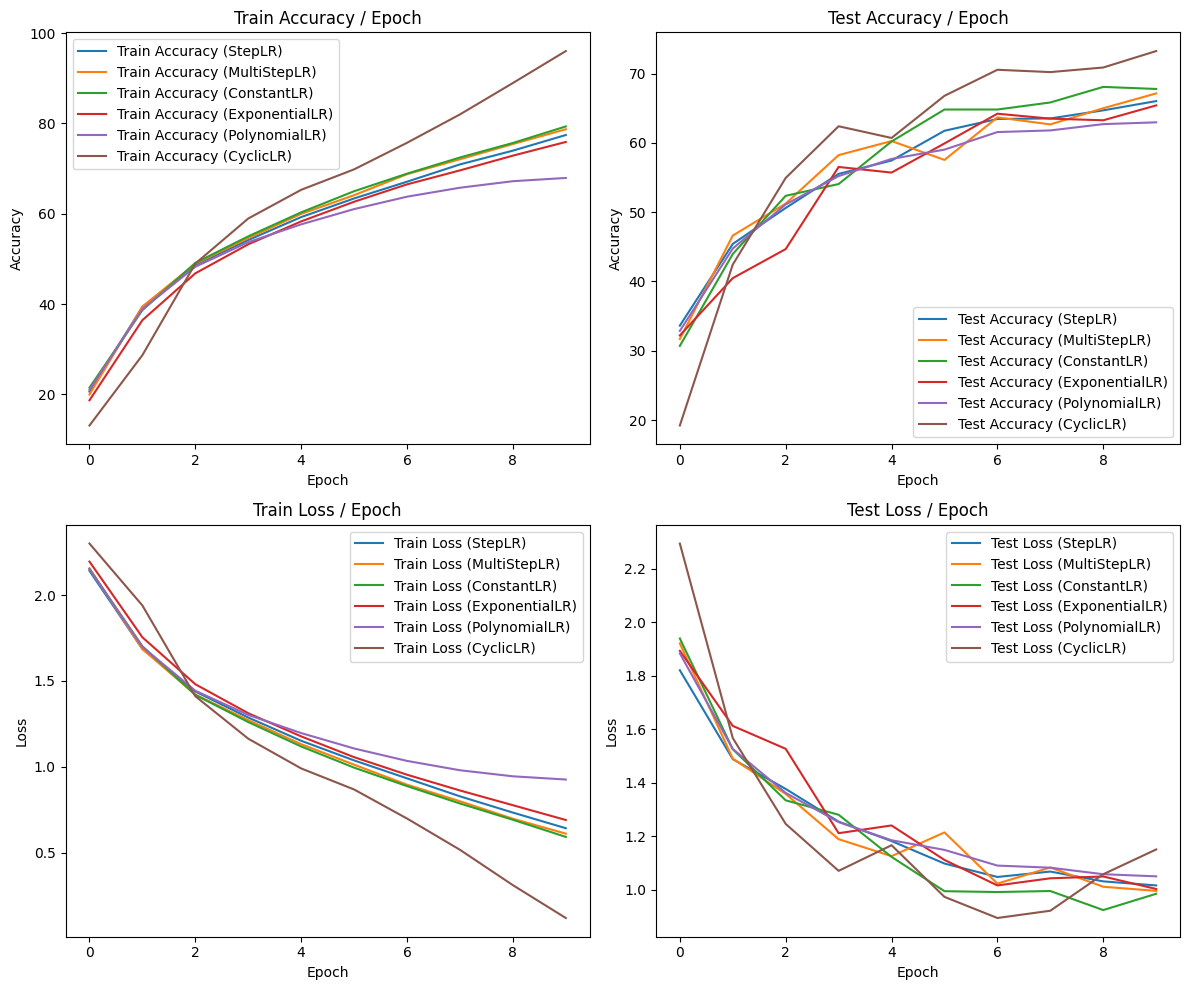

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Training Accuracy
for scheduler in lr_schedulers:
    axs[0, 0].plot(results[scheduler.__name__]['acc_train'], label=f'Train Accuracy ({scheduler.__name__})')
    axs[0, 0].set_title('Train Accuracy / Epoch')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()

# Test Accuracy
for scheduler in lr_schedulers:
    axs[0, 1].plot(results[scheduler.__name__]['acc_test'], label=f'Test Accuracy ({scheduler.__name__})')
    axs[0, 1].set_title('Test Accuracy / Epoch')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

# Training Loss
for scheduler in lr_schedulers:
    axs[1, 0].plot(results[scheduler.__name__]['loss_train'], label=f'Train Loss ({scheduler.__name__})')
    axs[1, 0].set_title('Train Loss / Epoch')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

# Test Loss
for scheduler in lr_schedulers:
    axs[1, 1].plot(results[scheduler.__name__]['loss_test'], label=f'Test Loss ({scheduler.__name__})')
    axs[1, 1].set_title('Test Loss / Epoch')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()

plt.tight_layout()
plt.show()

3.4

In [10]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self,p):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True ), # add ceil_mode=True

        )

        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output




In [14]:
model = ConvNet(0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD
lr = 0.1
batch_size = 128
cuda = True

opt = optimizer(model.parameters(), lr)
epochs = 10
results = {
    "acc_train": [],
    "acc_test": [],
    "loss_train": [],
    "loss_test": []
}
if cuda:  # Only with GPU, and not with CPU
    cudnn.benchmark = True
    model = model.cuda()
    criterion = criterion.cuda()

train, test = get_dataset2(datasets.CIFAR10,batch_size, cuda)


for e in range(epochs):

    # Train phase
    top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, opt, cuda)
    # Test phase
    top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

    # Store
    results['loss_train'].append(loss.avg)
    results['loss_test'].append(loss_test.avg)
    results['acc_train'].append(top1_acc.avg)
    results['acc_test'].append(top1_acc_test.avg)


100%|██████████| 170M/170M [00:05<00:00, 30.9MB/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


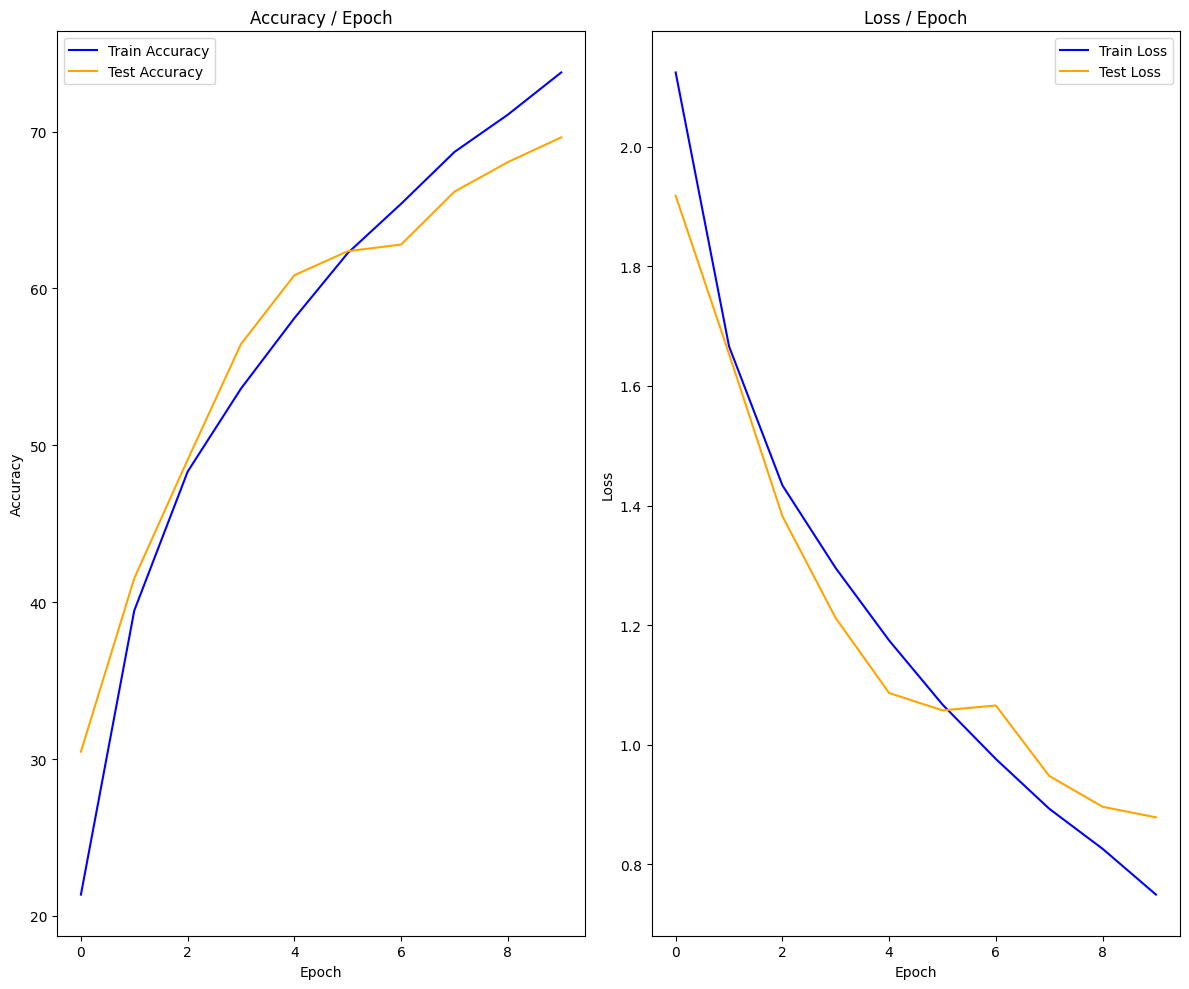

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# Accuracy
axs[0].plot(results['acc_train'], label=f'Train Accuracy', color='blue')
axs[0].plot(results['acc_test'], label=f'Test Accuracy', color='orange')
axs[0].set_title('Accuracy / Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(results['loss_train'], label=f'Train Loss', color='blue')
axs[1].plot(results['loss_test'], label=f'Test Loss', color='orange')
axs[1].set_title('Loss / Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [16]:
results = {}
for p in [0.1, 0.3, 0.5, 0.7, 1]:
    print(f"p={p}")
    model = ConvNet(p)
    criterion = nn.CrossEntropyLoss()
    opt = optimizer(model.parameters(), lr)

    results[p] = {
        "acc_train": [],
        "acc_test": [],
        "loss_train": [],
        "loss_test": []
    }
    if cuda:  # Only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    train, test = get_dataset2(datasets.CIFAR10,batch_size, cuda)


    for e in range(epochs):

        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, opt, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

        # Store
        results[p]['loss_train'].append(loss.avg)
        results[p]['loss_test'].append(loss_test.avg)
        results[p]['acc_train'].append(top1_acc.avg)
        results[p]['acc_test'].append(top1_acc_test.avg)

p=0.1
Files already downloaded and verified
Files already downloaded and verified
p=0.3
Files already downloaded and verified
Files already downloaded and verified
p=0.5
Files already downloaded and verified
Files already downloaded and verified
p=0.7
Files already downloaded and verified
Files already downloaded and verified
p=1
Files already downloaded and verified
Files already downloaded and verified


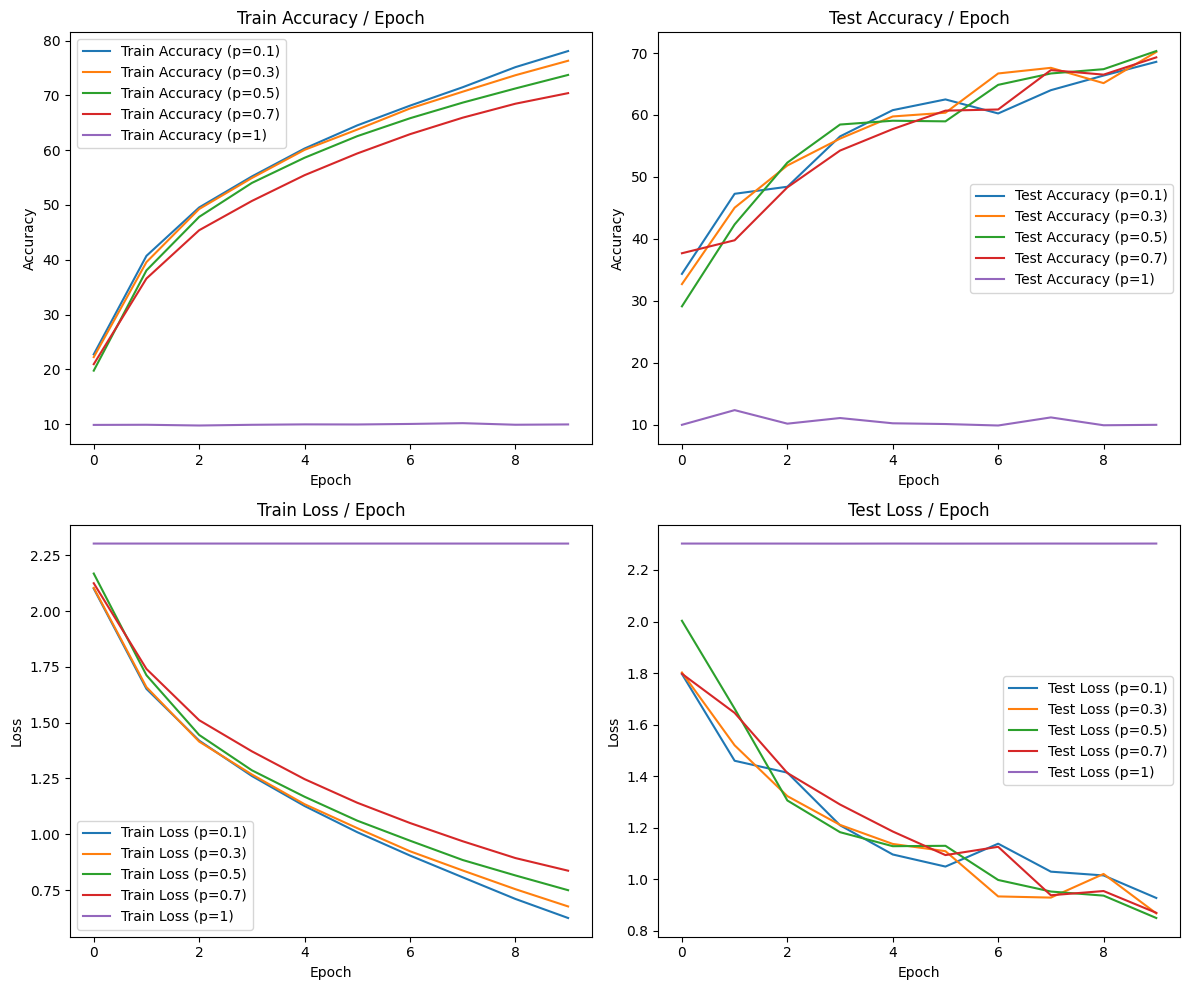

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Training Accuracy
for p in [0.1, 0.3, 0.5, 0.7, 1]:
    axs[0, 0].plot(results[p]['acc_train'], label=f'Train Accuracy (p={p})')
axs[0, 0].set_title('Train Accuracy / Epoch')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Test Accuracy
# Training Accuracy
for p in [0.1, 0.3, 0.5, 0.7, 1]:
    axs[0, 1].plot(results[p]['acc_test'], label=f'Test Accuracy (p={p})')
axs[0, 1].set_title('Test Accuracy / Epoch')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Training Loss
# Training Accuracy
for p in [0.1, 0.3, 0.5, 0.7, 1]:
    axs[1, 0].plot(results[p]['loss_train'], label=f'Train Loss (p={p})')
axs[1, 0].set_title('Train Loss / Epoch')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Test Loss
# Training Accuracy
for p in [0.1, 0.3, 0.5, 0.7, 1]:
    axs[1, 1].plot(results[p]['loss_test'], label=f'Test Loss (p={p})')
axs[1, 1].set_title('Test Loss / Epoch')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

3.5

In [18]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        #adding batch normalization after each convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True ), # add ceil_mode=True

        )

        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output




In [19]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
opt = optimizer(model.parameters(), lr)

results = {
    "acc_train": [],
    "acc_test": [],
    "loss_train": [],
    "loss_test": []
}
if cuda:  # Only with GPU, and not with CPU
    cudnn.benchmark = True
    model = model.cuda()
    criterion = criterion.cuda()

train, test = get_dataset2(datasets.CIFAR10,batch_size, cuda)


for e in range(epochs):

    # Train phase
    top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, opt, cuda)
    # Test phase
    top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

    # Store
    results['loss_train'].append(loss.avg)
    results['loss_test'].append(loss_test.avg)
    results['acc_train'].append(top1_acc.avg)
    results['acc_test'].append(top1_acc_test.avg)


Files already downloaded and verified
Files already downloaded and verified


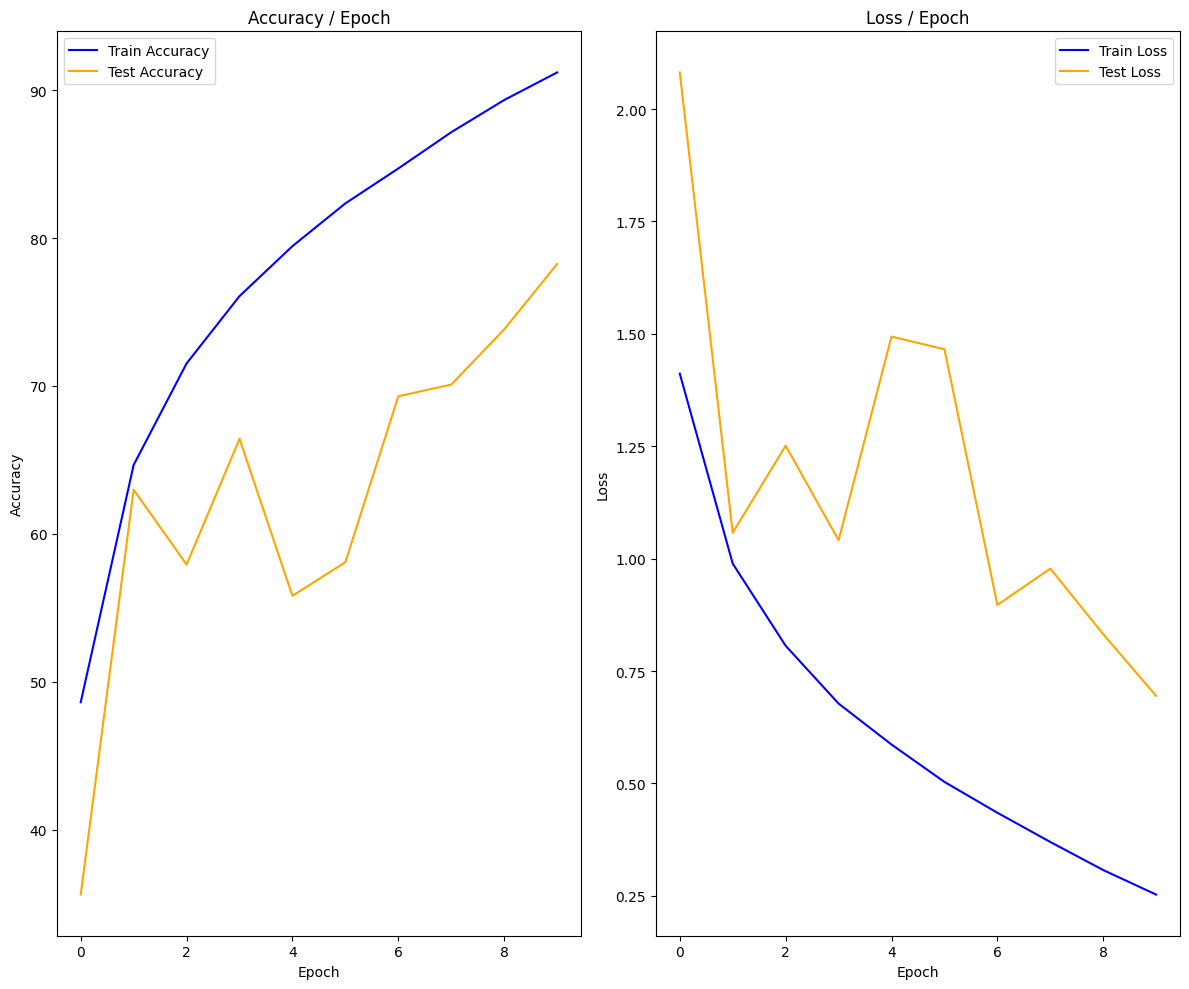

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

# Accuracy
axs[0].plot(results['acc_train'], label=f'Train Accuracy', color='blue')
axs[0].plot(results['acc_test'], label=f'Test Accuracy', color='orange')
axs[0].set_title('Accuracy / Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss
axs[1].plot(results['loss_train'], label=f'Train Loss', color='blue')
axs[1].plot(results['loss_test'], label=f'Test Loss', color='orange')
axs[1].set_title('Loss / Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()